# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

# helper.download_extract('mnist', data_dir)
# helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

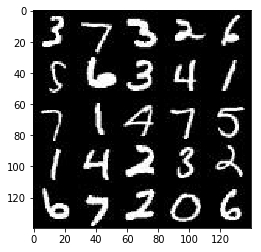

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

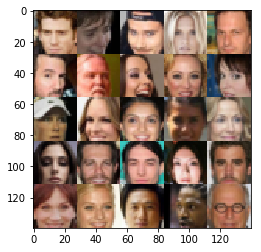

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/debadyuti/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], "input_z")
    learning_rate = tf.placeholder(tf.float32, None, "learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    
    def conv(inputs, filters, batch_norm=True):
        outputs = tf.layers.conv2d(inputs, filters, 5, 2, 'same')
        if batch_norm:
            outputs = tf.layers.batch_normalization(outputs, training=True)
        return leaky_relu(outputs)
        
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input 28*28*3
        x1 = conv(images, 64, batch_norm=False) # 14*14*64
        x2 = conv(x1, 128) # 7*7*128
        x3 = conv(x2, 256) # 4*4*256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 1, 'SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.layers.dropout(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 7*7*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, 'SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.layers.dropout(x3, training=is_train)
        x3 = leaky_relu(x3)
        # 14*14*128
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(logits)
        # 28*28*out_channel_dim
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * alpha))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        t_vars = tf.trainable_variables()
        
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 2.5859... Generator Loss: 0.1917
Epoch 1/2... Batch 20... Discriminator Loss: 1.2228... Generator Loss: 0.7064
Epoch 1/2... Batch 30... Discriminator Loss: 0.6223... Generator Loss: 6.0937
Epoch 1/2... Batch 40... Discriminator Loss: 1.7759... Generator Loss: 6.9386
Epoch 1/2... Batch 50... Discriminator Loss: 0.6322... Generator Loss: 1.8458
Epoch 1/2... Batch 60... Discriminator Loss: 0.6960... Generator Loss: 3.2341
Epoch 1/2... Batch 70... Discriminator Loss: 2.2977... Generator Loss: 0.3575
Epoch 1/2... Batch 80... Discriminator Loss: 0.9375... Generator Loss: 0.9889
Epoch 1/2... Batch 90... Discriminator Loss: 1.3986... Generator Loss: 0.4786
Epoch 1/2... Batch 100... Discriminator Loss: 1.7849... Generator Loss: 0.4016


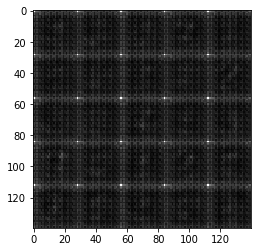

Epoch 1/2... Batch 110... Discriminator Loss: 1.0541... Generator Loss: 1.6034
Epoch 1/2... Batch 120... Discriminator Loss: 0.6982... Generator Loss: 1.8103
Epoch 1/2... Batch 130... Discriminator Loss: 0.7623... Generator Loss: 1.8548
Epoch 1/2... Batch 140... Discriminator Loss: 1.4224... Generator Loss: 0.5007
Epoch 1/2... Batch 150... Discriminator Loss: 0.8850... Generator Loss: 1.9683
Epoch 1/2... Batch 160... Discriminator Loss: 0.9592... Generator Loss: 2.1968
Epoch 1/2... Batch 170... Discriminator Loss: 0.9467... Generator Loss: 1.8488
Epoch 1/2... Batch 180... Discriminator Loss: 1.1608... Generator Loss: 0.6716
Epoch 1/2... Batch 190... Discriminator Loss: 1.0164... Generator Loss: 1.2502
Epoch 1/2... Batch 200... Discriminator Loss: 0.8437... Generator Loss: 1.1241


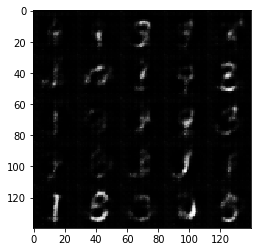

Epoch 1/2... Batch 210... Discriminator Loss: 1.0690... Generator Loss: 2.6633
Epoch 1/2... Batch 220... Discriminator Loss: 0.9056... Generator Loss: 1.0204
Epoch 1/2... Batch 230... Discriminator Loss: 1.1793... Generator Loss: 2.4200
Epoch 1/2... Batch 240... Discriminator Loss: 0.8870... Generator Loss: 1.3420
Epoch 1/2... Batch 250... Discriminator Loss: 1.5637... Generator Loss: 0.4035
Epoch 1/2... Batch 260... Discriminator Loss: 0.9781... Generator Loss: 2.4672
Epoch 1/2... Batch 270... Discriminator Loss: 1.1307... Generator Loss: 0.8359
Epoch 1/2... Batch 280... Discriminator Loss: 0.8034... Generator Loss: 1.6014
Epoch 1/2... Batch 290... Discriminator Loss: 1.3283... Generator Loss: 2.5839
Epoch 1/2... Batch 300... Discriminator Loss: 0.8545... Generator Loss: 1.4563


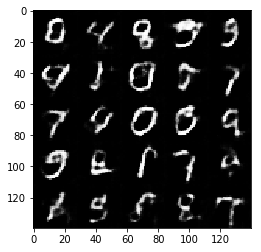

Epoch 1/2... Batch 310... Discriminator Loss: 0.8978... Generator Loss: 1.1715
Epoch 1/2... Batch 320... Discriminator Loss: 1.4895... Generator Loss: 0.5026
Epoch 1/2... Batch 330... Discriminator Loss: 0.9133... Generator Loss: 1.4572
Epoch 1/2... Batch 340... Discriminator Loss: 1.5941... Generator Loss: 0.3836
Epoch 1/2... Batch 350... Discriminator Loss: 0.9776... Generator Loss: 0.8448
Epoch 1/2... Batch 360... Discriminator Loss: 0.9171... Generator Loss: 1.0296
Epoch 1/2... Batch 370... Discriminator Loss: 1.2763... Generator Loss: 0.6916
Epoch 1/2... Batch 380... Discriminator Loss: 0.9117... Generator Loss: 1.0884
Epoch 1/2... Batch 390... Discriminator Loss: 1.6265... Generator Loss: 0.4163
Epoch 1/2... Batch 400... Discriminator Loss: 0.8586... Generator Loss: 1.9280


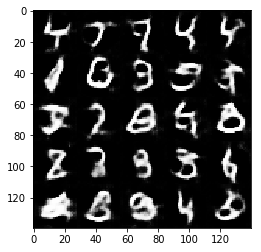

Epoch 1/2... Batch 410... Discriminator Loss: 1.1865... Generator Loss: 0.6179
Epoch 1/2... Batch 420... Discriminator Loss: 1.1526... Generator Loss: 0.7798
Epoch 1/2... Batch 430... Discriminator Loss: 1.8052... Generator Loss: 0.3756
Epoch 1/2... Batch 440... Discriminator Loss: 1.0964... Generator Loss: 0.8897
Epoch 1/2... Batch 450... Discriminator Loss: 1.0270... Generator Loss: 1.4588
Epoch 1/2... Batch 460... Discriminator Loss: 1.0824... Generator Loss: 0.8774
Epoch 1/2... Batch 470... Discriminator Loss: 1.1941... Generator Loss: 0.7243
Epoch 1/2... Batch 480... Discriminator Loss: 1.0918... Generator Loss: 0.7261
Epoch 1/2... Batch 490... Discriminator Loss: 0.9890... Generator Loss: 0.8772
Epoch 1/2... Batch 500... Discriminator Loss: 0.9379... Generator Loss: 0.9094


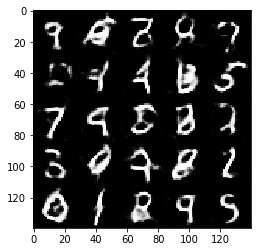

Epoch 1/2... Batch 510... Discriminator Loss: 1.5008... Generator Loss: 0.4779
Epoch 1/2... Batch 520... Discriminator Loss: 0.9348... Generator Loss: 0.8752
Epoch 1/2... Batch 530... Discriminator Loss: 1.3504... Generator Loss: 2.9275
Epoch 1/2... Batch 540... Discriminator Loss: 0.9639... Generator Loss: 1.8175
Epoch 1/2... Batch 550... Discriminator Loss: 0.9557... Generator Loss: 2.4162
Epoch 1/2... Batch 560... Discriminator Loss: 0.9995... Generator Loss: 0.9181
Epoch 1/2... Batch 570... Discriminator Loss: 0.6872... Generator Loss: 1.6785
Epoch 1/2... Batch 580... Discriminator Loss: 0.8580... Generator Loss: 1.1312
Epoch 1/2... Batch 590... Discriminator Loss: 0.8814... Generator Loss: 1.0423
Epoch 1/2... Batch 600... Discriminator Loss: 0.8343... Generator Loss: 1.9995


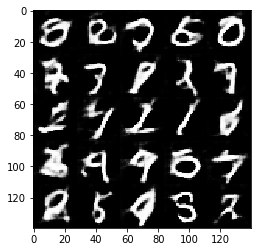

Epoch 1/2... Batch 610... Discriminator Loss: 0.7408... Generator Loss: 1.8276
Epoch 1/2... Batch 620... Discriminator Loss: 0.8906... Generator Loss: 1.1246
Epoch 1/2... Batch 630... Discriminator Loss: 1.0521... Generator Loss: 0.7858
Epoch 1/2... Batch 640... Discriminator Loss: 0.9287... Generator Loss: 2.5764
Epoch 1/2... Batch 650... Discriminator Loss: 0.9945... Generator Loss: 2.1716
Epoch 1/2... Batch 660... Discriminator Loss: 0.9443... Generator Loss: 0.8976
Epoch 1/2... Batch 670... Discriminator Loss: 0.7547... Generator Loss: 2.0014
Epoch 1/2... Batch 680... Discriminator Loss: 1.2564... Generator Loss: 0.6365
Epoch 1/2... Batch 690... Discriminator Loss: 0.7207... Generator Loss: 1.5757
Epoch 1/2... Batch 700... Discriminator Loss: 0.7968... Generator Loss: 1.8345


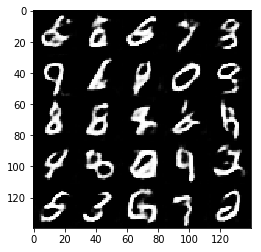

Epoch 1/2... Batch 710... Discriminator Loss: 0.8479... Generator Loss: 0.9777
Epoch 1/2... Batch 720... Discriminator Loss: 0.7805... Generator Loss: 1.3768
Epoch 1/2... Batch 730... Discriminator Loss: 0.6350... Generator Loss: 1.3845
Epoch 1/2... Batch 740... Discriminator Loss: 1.0325... Generator Loss: 1.5290
Epoch 1/2... Batch 750... Discriminator Loss: 1.1775... Generator Loss: 0.6234
Epoch 1/2... Batch 760... Discriminator Loss: 0.8035... Generator Loss: 1.3250
Epoch 1/2... Batch 770... Discriminator Loss: 0.7844... Generator Loss: 1.3453
Epoch 1/2... Batch 780... Discriminator Loss: 0.7558... Generator Loss: 1.5662
Epoch 1/2... Batch 790... Discriminator Loss: 0.7561... Generator Loss: 1.4008
Epoch 1/2... Batch 800... Discriminator Loss: 0.7390... Generator Loss: 1.6117


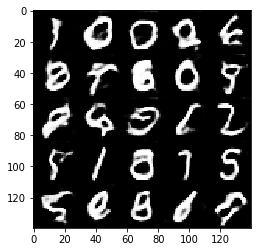

Epoch 1/2... Batch 810... Discriminator Loss: 0.7008... Generator Loss: 2.4022
Epoch 1/2... Batch 820... Discriminator Loss: 0.8472... Generator Loss: 2.0006
Epoch 1/2... Batch 830... Discriminator Loss: 0.6625... Generator Loss: 1.5493
Epoch 1/2... Batch 840... Discriminator Loss: 1.0149... Generator Loss: 2.8018
Epoch 1/2... Batch 850... Discriminator Loss: 0.7155... Generator Loss: 1.4287
Epoch 1/2... Batch 860... Discriminator Loss: 0.8960... Generator Loss: 0.8997
Epoch 1/2... Batch 870... Discriminator Loss: 0.7643... Generator Loss: 1.3524
Epoch 1/2... Batch 880... Discriminator Loss: 0.9024... Generator Loss: 1.6844
Epoch 1/2... Batch 890... Discriminator Loss: 0.9722... Generator Loss: 1.0041
Epoch 1/2... Batch 900... Discriminator Loss: 0.8489... Generator Loss: 2.5232


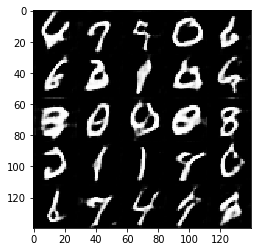

Epoch 1/2... Batch 910... Discriminator Loss: 0.9797... Generator Loss: 2.5256
Epoch 1/2... Batch 920... Discriminator Loss: 0.7778... Generator Loss: 2.3371
Epoch 1/2... Batch 930... Discriminator Loss: 1.6032... Generator Loss: 3.6093
Epoch 1/2... Batch 940... Discriminator Loss: 0.6023... Generator Loss: 2.2524
Epoch 1/2... Batch 950... Discriminator Loss: 0.7960... Generator Loss: 2.4625
Epoch 1/2... Batch 960... Discriminator Loss: 0.6968... Generator Loss: 1.4799
Epoch 1/2... Batch 970... Discriminator Loss: 1.7694... Generator Loss: 0.4791
Epoch 1/2... Batch 980... Discriminator Loss: 0.7610... Generator Loss: 1.2940
Epoch 1/2... Batch 990... Discriminator Loss: 0.6537... Generator Loss: 1.9485
Epoch 1/2... Batch 1000... Discriminator Loss: 0.5805... Generator Loss: 2.3481


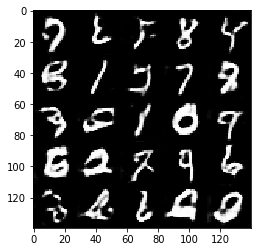

Epoch 1/2... Batch 1010... Discriminator Loss: 0.7044... Generator Loss: 1.3187
Epoch 1/2... Batch 1020... Discriminator Loss: 0.9326... Generator Loss: 2.3734
Epoch 1/2... Batch 1030... Discriminator Loss: 0.9005... Generator Loss: 1.3226
Epoch 1/2... Batch 1040... Discriminator Loss: 0.7743... Generator Loss: 1.5036
Epoch 1/2... Batch 1050... Discriminator Loss: 0.9715... Generator Loss: 3.2484
Epoch 1/2... Batch 1060... Discriminator Loss: 0.9128... Generator Loss: 1.2024
Epoch 1/2... Batch 1070... Discriminator Loss: 0.9583... Generator Loss: 1.0608
Epoch 1/2... Batch 1080... Discriminator Loss: 0.7153... Generator Loss: 2.0508
Epoch 1/2... Batch 1090... Discriminator Loss: 0.6884... Generator Loss: 2.0616
Epoch 1/2... Batch 1100... Discriminator Loss: 0.6648... Generator Loss: 2.3114


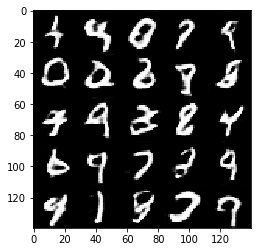

Epoch 1/2... Batch 1110... Discriminator Loss: 0.5263... Generator Loss: 2.1474
Epoch 1/2... Batch 1120... Discriminator Loss: 0.9843... Generator Loss: 0.9874
Epoch 1/2... Batch 1130... Discriminator Loss: 0.6334... Generator Loss: 2.7468
Epoch 1/2... Batch 1140... Discriminator Loss: 0.6275... Generator Loss: 2.0686
Epoch 1/2... Batch 1150... Discriminator Loss: 0.6067... Generator Loss: 1.6203
Epoch 1/2... Batch 1160... Discriminator Loss: 0.6232... Generator Loss: 2.0353
Epoch 1/2... Batch 1170... Discriminator Loss: 1.1243... Generator Loss: 3.2786
Epoch 1/2... Batch 1180... Discriminator Loss: 0.7626... Generator Loss: 2.2617
Epoch 1/2... Batch 1190... Discriminator Loss: 0.6495... Generator Loss: 1.5818
Epoch 1/2... Batch 1200... Discriminator Loss: 0.8300... Generator Loss: 1.4160


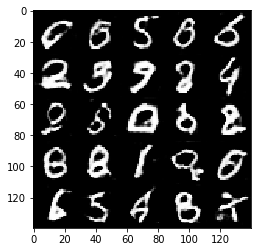

Epoch 1/2... Batch 1210... Discriminator Loss: 1.0395... Generator Loss: 1.0544
Epoch 1/2... Batch 1220... Discriminator Loss: 0.6049... Generator Loss: 1.8552
Epoch 1/2... Batch 1230... Discriminator Loss: 0.9112... Generator Loss: 3.1909
Epoch 1/2... Batch 1240... Discriminator Loss: 0.8885... Generator Loss: 1.1834
Epoch 1/2... Batch 1250... Discriminator Loss: 1.0687... Generator Loss: 1.1817
Epoch 1/2... Batch 1260... Discriminator Loss: 0.6418... Generator Loss: 1.8555
Epoch 1/2... Batch 1270... Discriminator Loss: 0.6481... Generator Loss: 1.9999
Epoch 1/2... Batch 1280... Discriminator Loss: 0.6751... Generator Loss: 1.1020
Epoch 1/2... Batch 1290... Discriminator Loss: 0.5599... Generator Loss: 1.7758
Epoch 1/2... Batch 1300... Discriminator Loss: 0.6021... Generator Loss: 1.9325


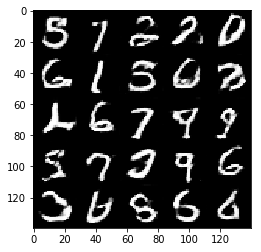

Epoch 1/2... Batch 1310... Discriminator Loss: 1.9213... Generator Loss: 0.3167
Epoch 1/2... Batch 1320... Discriminator Loss: 0.7951... Generator Loss: 1.5656
Epoch 1/2... Batch 1330... Discriminator Loss: 0.7543... Generator Loss: 1.4363
Epoch 1/2... Batch 1340... Discriminator Loss: 0.9290... Generator Loss: 1.5104
Epoch 1/2... Batch 1350... Discriminator Loss: 0.5530... Generator Loss: 2.8455
Epoch 1/2... Batch 1360... Discriminator Loss: 0.4759... Generator Loss: 2.1318
Epoch 1/2... Batch 1370... Discriminator Loss: 0.5060... Generator Loss: 2.6779
Epoch 1/2... Batch 1380... Discriminator Loss: 0.9141... Generator Loss: 1.4462
Epoch 1/2... Batch 1390... Discriminator Loss: 0.5894... Generator Loss: 2.0486
Epoch 1/2... Batch 1400... Discriminator Loss: 1.5141... Generator Loss: 0.7721


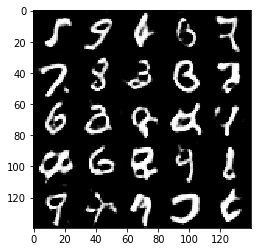

Epoch 1/2... Batch 1410... Discriminator Loss: 0.6291... Generator Loss: 1.7491
Epoch 1/2... Batch 1420... Discriminator Loss: 0.7006... Generator Loss: 1.6115
Epoch 1/2... Batch 1430... Discriminator Loss: 0.6480... Generator Loss: 2.0914
Epoch 1/2... Batch 1440... Discriminator Loss: 0.6035... Generator Loss: 1.6157
Epoch 1/2... Batch 1450... Discriminator Loss: 0.6850... Generator Loss: 2.6784
Epoch 1/2... Batch 1460... Discriminator Loss: 0.4903... Generator Loss: 2.6967
Epoch 1/2... Batch 1470... Discriminator Loss: 0.5413... Generator Loss: 2.1102
Epoch 1/2... Batch 1480... Discriminator Loss: 0.5324... Generator Loss: 1.7385
Epoch 1/2... Batch 1490... Discriminator Loss: 1.6091... Generator Loss: 0.4555
Epoch 1/2... Batch 1500... Discriminator Loss: 0.7498... Generator Loss: 1.3146


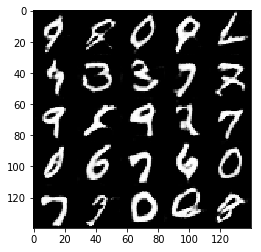

Epoch 1/2... Batch 1510... Discriminator Loss: 1.1326... Generator Loss: 0.6835
Epoch 1/2... Batch 1520... Discriminator Loss: 1.2641... Generator Loss: 0.8637
Epoch 1/2... Batch 1530... Discriminator Loss: 1.2574... Generator Loss: 0.7970
Epoch 1/2... Batch 1540... Discriminator Loss: 0.5989... Generator Loss: 1.8209
Epoch 1/2... Batch 1550... Discriminator Loss: 0.7991... Generator Loss: 2.7449
Epoch 1/2... Batch 1560... Discriminator Loss: 0.8190... Generator Loss: 1.4569
Epoch 1/2... Batch 1570... Discriminator Loss: 0.6722... Generator Loss: 1.6427
Epoch 1/2... Batch 1580... Discriminator Loss: 0.6089... Generator Loss: 1.8953
Epoch 1/2... Batch 1590... Discriminator Loss: 0.5320... Generator Loss: 2.2953
Epoch 1/2... Batch 1600... Discriminator Loss: 0.7889... Generator Loss: 2.7473


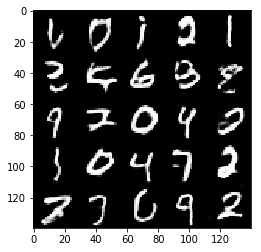

Epoch 1/2... Batch 1610... Discriminator Loss: 0.7501... Generator Loss: 1.4724
Epoch 1/2... Batch 1620... Discriminator Loss: 0.6199... Generator Loss: 2.9801
Epoch 1/2... Batch 1630... Discriminator Loss: 0.4613... Generator Loss: 2.4001
Epoch 1/2... Batch 1640... Discriminator Loss: 0.7924... Generator Loss: 1.4176
Epoch 1/2... Batch 1650... Discriminator Loss: 0.7944... Generator Loss: 1.1399
Epoch 1/2... Batch 1660... Discriminator Loss: 0.5226... Generator Loss: 2.1251
Epoch 1/2... Batch 1670... Discriminator Loss: 0.6435... Generator Loss: 3.7093
Epoch 1/2... Batch 1680... Discriminator Loss: 0.5693... Generator Loss: 2.1887
Epoch 1/2... Batch 1690... Discriminator Loss: 0.4916... Generator Loss: 2.7808
Epoch 1/2... Batch 1700... Discriminator Loss: 0.5447... Generator Loss: 2.1620


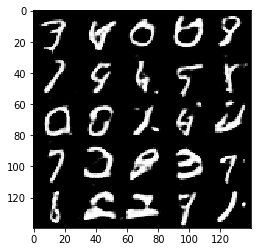

Epoch 1/2... Batch 1710... Discriminator Loss: 0.7007... Generator Loss: 1.6570
Epoch 1/2... Batch 1720... Discriminator Loss: 0.7501... Generator Loss: 1.2800
Epoch 1/2... Batch 1730... Discriminator Loss: 0.5599... Generator Loss: 2.2326
Epoch 1/2... Batch 1740... Discriminator Loss: 0.7044... Generator Loss: 1.7321
Epoch 1/2... Batch 1750... Discriminator Loss: 0.5465... Generator Loss: 2.2045
Epoch 1/2... Batch 1760... Discriminator Loss: 0.4622... Generator Loss: 2.3544
Epoch 1/2... Batch 1770... Discriminator Loss: 0.4889... Generator Loss: 2.4027
Epoch 1/2... Batch 1780... Discriminator Loss: 0.5072... Generator Loss: 2.9548
Epoch 1/2... Batch 1790... Discriminator Loss: 0.4859... Generator Loss: 2.9913
Epoch 1/2... Batch 1800... Discriminator Loss: 0.4197... Generator Loss: 3.2867


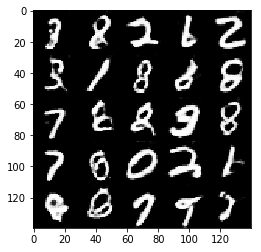

Epoch 1/2... Batch 1810... Discriminator Loss: 0.5941... Generator Loss: 2.1806
Epoch 1/2... Batch 1820... Discriminator Loss: 0.4643... Generator Loss: 2.4451
Epoch 1/2... Batch 1830... Discriminator Loss: 0.4520... Generator Loss: 2.4171
Epoch 1/2... Batch 1840... Discriminator Loss: 0.4581... Generator Loss: 3.1493
Epoch 1/2... Batch 1850... Discriminator Loss: 0.4915... Generator Loss: 1.9885
Epoch 1/2... Batch 1860... Discriminator Loss: 0.4266... Generator Loss: 2.9098
Epoch 1/2... Batch 1870... Discriminator Loss: 0.4716... Generator Loss: 3.1898
Epoch 2/2... Batch 10... Discriminator Loss: 0.5219... Generator Loss: 2.0636
Epoch 2/2... Batch 20... Discriminator Loss: 0.8378... Generator Loss: 0.9498
Epoch 2/2... Batch 30... Discriminator Loss: 0.6641... Generator Loss: 2.0908
Epoch 2/2... Batch 40... Discriminator Loss: 0.4739... Generator Loss: 2.6235
Epoch 2/2... Batch 50... Discriminator Loss: 2.9043... Generator Loss: 0.2790
Epoch 2/2... Batch 60... Discriminator Loss: 0.602

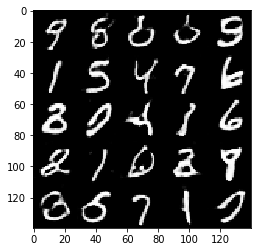

Epoch 2/2... Batch 110... Discriminator Loss: 0.5112... Generator Loss: 2.6631
Epoch 2/2... Batch 120... Discriminator Loss: 0.5733... Generator Loss: 3.6597
Epoch 2/2... Batch 130... Discriminator Loss: 0.8618... Generator Loss: 1.2533
Epoch 2/2... Batch 140... Discriminator Loss: 1.4025... Generator Loss: 0.8347
Epoch 2/2... Batch 150... Discriminator Loss: 0.6286... Generator Loss: 2.3048
Epoch 2/2... Batch 160... Discriminator Loss: 0.4202... Generator Loss: 2.9257
Epoch 2/2... Batch 170... Discriminator Loss: 0.4425... Generator Loss: 2.1214
Epoch 2/2... Batch 180... Discriminator Loss: 0.4947... Generator Loss: 2.5691
Epoch 2/2... Batch 190... Discriminator Loss: 0.8876... Generator Loss: 1.1268
Epoch 2/2... Batch 200... Discriminator Loss: 0.4946... Generator Loss: 2.5286


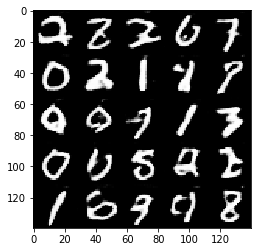

Epoch 2/2... Batch 210... Discriminator Loss: 0.4753... Generator Loss: 3.4250
Epoch 2/2... Batch 220... Discriminator Loss: 0.5484... Generator Loss: 4.0860
Epoch 2/2... Batch 230... Discriminator Loss: 0.5533... Generator Loss: 2.3925
Epoch 2/2... Batch 240... Discriminator Loss: 0.4109... Generator Loss: 3.3863
Epoch 2/2... Batch 250... Discriminator Loss: 0.7299... Generator Loss: 3.3142
Epoch 2/2... Batch 260... Discriminator Loss: 0.6454... Generator Loss: 3.9502
Epoch 2/2... Batch 270... Discriminator Loss: 0.7472... Generator Loss: 3.6215
Epoch 2/2... Batch 280... Discriminator Loss: 0.4542... Generator Loss: 3.0004
Epoch 2/2... Batch 290... Discriminator Loss: 0.4897... Generator Loss: 3.1828
Epoch 2/2... Batch 300... Discriminator Loss: 0.6910... Generator Loss: 1.9235


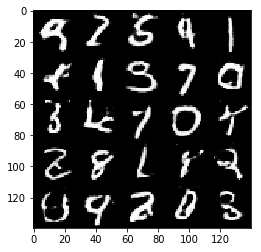

Epoch 2/2... Batch 310... Discriminator Loss: 0.4358... Generator Loss: 2.7206
Epoch 2/2... Batch 320... Discriminator Loss: 0.4946... Generator Loss: 2.5478
Epoch 2/2... Batch 330... Discriminator Loss: 1.5358... Generator Loss: 0.7080
Epoch 2/2... Batch 340... Discriminator Loss: 0.6490... Generator Loss: 1.7013
Epoch 2/2... Batch 350... Discriminator Loss: 0.4725... Generator Loss: 3.0261
Epoch 2/2... Batch 360... Discriminator Loss: 0.5006... Generator Loss: 3.1558
Epoch 2/2... Batch 370... Discriminator Loss: 0.5138... Generator Loss: 2.4462
Epoch 2/2... Batch 380... Discriminator Loss: 0.3922... Generator Loss: 2.9268
Epoch 2/2... Batch 390... Discriminator Loss: 0.4274... Generator Loss: 2.8264
Epoch 2/2... Batch 400... Discriminator Loss: 0.4064... Generator Loss: 3.8507


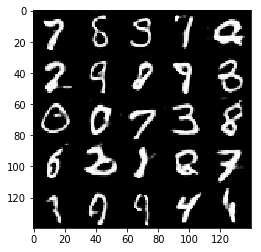

Epoch 2/2... Batch 410... Discriminator Loss: 0.4178... Generator Loss: 4.0897
Epoch 2/2... Batch 420... Discriminator Loss: 0.6201... Generator Loss: 2.0174
Epoch 2/2... Batch 430... Discriminator Loss: 0.4380... Generator Loss: 2.8831
Epoch 2/2... Batch 440... Discriminator Loss: 0.4013... Generator Loss: 3.8640
Epoch 2/2... Batch 450... Discriminator Loss: 0.4102... Generator Loss: 2.5118
Epoch 2/2... Batch 460... Discriminator Loss: 0.3753... Generator Loss: 3.7672
Epoch 2/2... Batch 470... Discriminator Loss: 0.3965... Generator Loss: 3.2360
Epoch 2/2... Batch 480... Discriminator Loss: 0.4562... Generator Loss: 3.8031
Epoch 2/2... Batch 490... Discriminator Loss: 0.4027... Generator Loss: 3.7958
Epoch 2/2... Batch 500... Discriminator Loss: 0.4090... Generator Loss: 2.4743


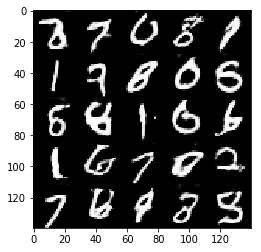

Epoch 2/2... Batch 510... Discriminator Loss: 0.5064... Generator Loss: 2.0928
Epoch 2/2... Batch 520... Discriminator Loss: 5.4170... Generator Loss: 9.7677
Epoch 2/2... Batch 530... Discriminator Loss: 0.7235... Generator Loss: 2.5840
Epoch 2/2... Batch 540... Discriminator Loss: 0.5426... Generator Loss: 2.1573
Epoch 2/2... Batch 550... Discriminator Loss: 0.7851... Generator Loss: 3.3685
Epoch 2/2... Batch 560... Discriminator Loss: 0.4283... Generator Loss: 3.2369
Epoch 2/2... Batch 570... Discriminator Loss: 0.4666... Generator Loss: 2.6725
Epoch 2/2... Batch 580... Discriminator Loss: 0.3969... Generator Loss: 2.9381
Epoch 2/2... Batch 590... Discriminator Loss: 0.4593... Generator Loss: 2.7731
Epoch 2/2... Batch 600... Discriminator Loss: 0.5019... Generator Loss: 2.2713


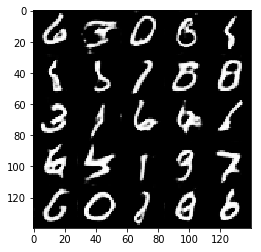

Epoch 2/2... Batch 610... Discriminator Loss: 0.5575... Generator Loss: 2.0124
Epoch 2/2... Batch 620... Discriminator Loss: 0.8554... Generator Loss: 1.3826
Epoch 2/2... Batch 630... Discriminator Loss: 0.5670... Generator Loss: 1.7235
Epoch 2/2... Batch 640... Discriminator Loss: 0.4124... Generator Loss: 2.8951
Epoch 2/2... Batch 650... Discriminator Loss: 0.4997... Generator Loss: 3.6079
Epoch 2/2... Batch 660... Discriminator Loss: 0.6374... Generator Loss: 1.6918
Epoch 2/2... Batch 670... Discriminator Loss: 0.3670... Generator Loss: 3.6106
Epoch 2/2... Batch 680... Discriminator Loss: 0.7913... Generator Loss: 1.5474
Epoch 2/2... Batch 690... Discriminator Loss: 0.6138... Generator Loss: 1.9829
Epoch 2/2... Batch 700... Discriminator Loss: 0.7323... Generator Loss: 1.7166


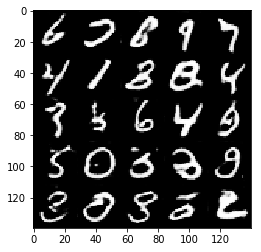

Epoch 2/2... Batch 710... Discriminator Loss: 0.4696... Generator Loss: 2.0501
Epoch 2/2... Batch 720... Discriminator Loss: 1.5093... Generator Loss: 4.6584
Epoch 2/2... Batch 730... Discriminator Loss: 0.4133... Generator Loss: 3.5974
Epoch 2/2... Batch 740... Discriminator Loss: 0.6147... Generator Loss: 4.2085
Epoch 2/2... Batch 750... Discriminator Loss: 0.9661... Generator Loss: 1.2951
Epoch 2/2... Batch 760... Discriminator Loss: 0.4823... Generator Loss: 2.7095
Epoch 2/2... Batch 770... Discriminator Loss: 0.5669... Generator Loss: 2.3476
Epoch 2/2... Batch 780... Discriminator Loss: 0.4874... Generator Loss: 1.7782
Epoch 2/2... Batch 790... Discriminator Loss: 0.6149... Generator Loss: 1.9221
Epoch 2/2... Batch 800... Discriminator Loss: 0.4375... Generator Loss: 2.8567


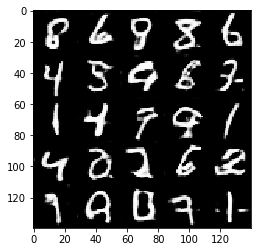

Epoch 2/2... Batch 810... Discriminator Loss: 0.3974... Generator Loss: 3.0453
Epoch 2/2... Batch 820... Discriminator Loss: 0.3709... Generator Loss: 3.5227
Epoch 2/2... Batch 830... Discriminator Loss: 0.4831... Generator Loss: 2.4978
Epoch 2/2... Batch 840... Discriminator Loss: 0.4631... Generator Loss: 3.8435
Epoch 2/2... Batch 850... Discriminator Loss: 0.5710... Generator Loss: 1.8134
Epoch 2/2... Batch 860... Discriminator Loss: 0.4030... Generator Loss: 2.8567
Epoch 2/2... Batch 870... Discriminator Loss: 0.4298... Generator Loss: 3.1255
Epoch 2/2... Batch 880... Discriminator Loss: 0.4065... Generator Loss: 2.9528
Epoch 2/2... Batch 890... Discriminator Loss: 0.3950... Generator Loss: 2.9395
Epoch 2/2... Batch 900... Discriminator Loss: 0.4100... Generator Loss: 3.1120


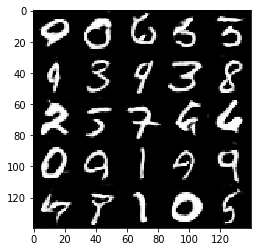

Epoch 2/2... Batch 910... Discriminator Loss: 1.5893... Generator Loss: 0.4376
Epoch 2/2... Batch 920... Discriminator Loss: 1.0926... Generator Loss: 0.8258
Epoch 2/2... Batch 930... Discriminator Loss: 0.6460... Generator Loss: 1.3763
Epoch 2/2... Batch 940... Discriminator Loss: 0.5264... Generator Loss: 2.2612
Epoch 2/2... Batch 950... Discriminator Loss: 0.4587... Generator Loss: 2.5724
Epoch 2/2... Batch 960... Discriminator Loss: 0.4603... Generator Loss: 2.6193
Epoch 2/2... Batch 970... Discriminator Loss: 1.5019... Generator Loss: 0.5948
Epoch 2/2... Batch 980... Discriminator Loss: 0.5553... Generator Loss: 2.0789
Epoch 2/2... Batch 990... Discriminator Loss: 0.4415... Generator Loss: 2.7617
Epoch 2/2... Batch 1000... Discriminator Loss: 0.4299... Generator Loss: 2.1867


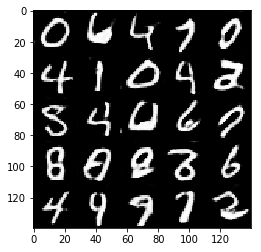

Epoch 2/2... Batch 1010... Discriminator Loss: 0.7720... Generator Loss: 1.1596
Epoch 2/2... Batch 1020... Discriminator Loss: 0.4886... Generator Loss: 2.8273
Epoch 2/2... Batch 1030... Discriminator Loss: 0.4405... Generator Loss: 2.6113
Epoch 2/2... Batch 1040... Discriminator Loss: 0.4646... Generator Loss: 2.6998
Epoch 2/2... Batch 1050... Discriminator Loss: 0.5369... Generator Loss: 3.4738
Epoch 2/2... Batch 1060... Discriminator Loss: 0.4334... Generator Loss: 3.0335
Epoch 2/2... Batch 1070... Discriminator Loss: 0.4149... Generator Loss: 3.4222
Epoch 2/2... Batch 1080... Discriminator Loss: 0.3999... Generator Loss: 3.6357
Epoch 2/2... Batch 1090... Discriminator Loss: 0.5044... Generator Loss: 2.2421
Epoch 2/2... Batch 1100... Discriminator Loss: 0.4089... Generator Loss: 3.7056


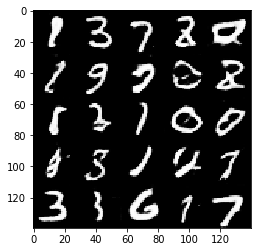

Epoch 2/2... Batch 1110... Discriminator Loss: 0.4172... Generator Loss: 3.8373
Epoch 2/2... Batch 1120... Discriminator Loss: 0.5085... Generator Loss: 2.4802
Epoch 2/2... Batch 1130... Discriminator Loss: 0.5430... Generator Loss: 4.7825
Epoch 2/2... Batch 1140... Discriminator Loss: 0.7255... Generator Loss: 2.6511
Epoch 2/2... Batch 1150... Discriminator Loss: 0.4235... Generator Loss: 2.9359
Epoch 2/2... Batch 1160... Discriminator Loss: 0.5669... Generator Loss: 1.9265
Epoch 2/2... Batch 1170... Discriminator Loss: 0.3914... Generator Loss: 3.3104
Epoch 2/2... Batch 1180... Discriminator Loss: 0.4140... Generator Loss: 3.2441
Epoch 2/2... Batch 1190... Discriminator Loss: 0.5025... Generator Loss: 2.2105
Epoch 2/2... Batch 1200... Discriminator Loss: 0.3849... Generator Loss: 3.4628


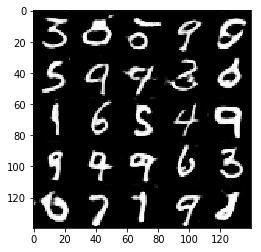

Epoch 2/2... Batch 1210... Discriminator Loss: 0.8590... Generator Loss: 1.3616
Epoch 2/2... Batch 1220... Discriminator Loss: 0.7879... Generator Loss: 1.8022
Epoch 2/2... Batch 1230... Discriminator Loss: 0.4182... Generator Loss: 3.1846
Epoch 2/2... Batch 1240... Discriminator Loss: 0.5211... Generator Loss: 1.9541
Epoch 2/2... Batch 1250... Discriminator Loss: 1.7558... Generator Loss: 0.7456
Epoch 2/2... Batch 1260... Discriminator Loss: 0.4150... Generator Loss: 3.7378
Epoch 2/2... Batch 1270... Discriminator Loss: 0.4297... Generator Loss: 2.6313
Epoch 2/2... Batch 1280... Discriminator Loss: 0.4940... Generator Loss: 3.0712
Epoch 2/2... Batch 1290... Discriminator Loss: 0.6093... Generator Loss: 3.5143
Epoch 2/2... Batch 1300... Discriminator Loss: 0.5650... Generator Loss: 3.9420


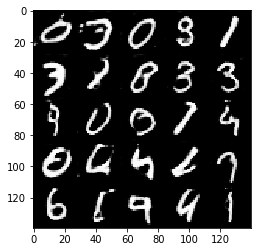

Epoch 2/2... Batch 1310... Discriminator Loss: 0.5507... Generator Loss: 2.6058
Epoch 2/2... Batch 1320... Discriminator Loss: 0.4554... Generator Loss: 3.4499
Epoch 2/2... Batch 1330... Discriminator Loss: 0.4269... Generator Loss: 3.1933
Epoch 2/2... Batch 1340... Discriminator Loss: 0.4390... Generator Loss: 3.0214
Epoch 2/2... Batch 1350... Discriminator Loss: 0.4724... Generator Loss: 4.5912
Epoch 2/2... Batch 1360... Discriminator Loss: 0.6862... Generator Loss: 1.4214
Epoch 2/2... Batch 1370... Discriminator Loss: 0.5401... Generator Loss: 2.2342
Epoch 2/2... Batch 1380... Discriminator Loss: 0.4585... Generator Loss: 2.8518
Epoch 2/2... Batch 1390... Discriminator Loss: 0.4944... Generator Loss: 2.6976
Epoch 2/2... Batch 1400... Discriminator Loss: 0.7713... Generator Loss: 1.5797


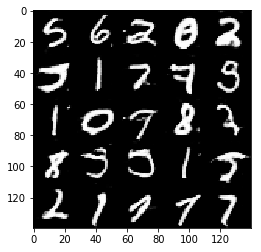

Epoch 2/2... Batch 1410... Discriminator Loss: 0.7435... Generator Loss: 4.2591
Epoch 2/2... Batch 1420... Discriminator Loss: 0.5088... Generator Loss: 3.6539
Epoch 2/2... Batch 1430... Discriminator Loss: 0.4702... Generator Loss: 3.1219
Epoch 2/2... Batch 1440... Discriminator Loss: 0.5570... Generator Loss: 2.1673
Epoch 2/2... Batch 1450... Discriminator Loss: 0.8382... Generator Loss: 1.3584
Epoch 2/2... Batch 1460... Discriminator Loss: 0.6898... Generator Loss: 3.3887
Epoch 2/2... Batch 1470... Discriminator Loss: 0.4453... Generator Loss: 2.9281
Epoch 2/2... Batch 1480... Discriminator Loss: 0.4311... Generator Loss: 2.5926
Epoch 2/2... Batch 1490... Discriminator Loss: 0.4298... Generator Loss: 2.5041
Epoch 2/2... Batch 1500... Discriminator Loss: 0.4268... Generator Loss: 2.2987


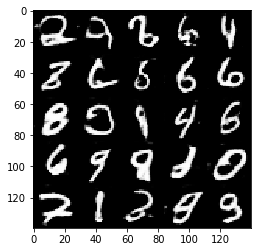

Epoch 2/2... Batch 1510... Discriminator Loss: 0.4236... Generator Loss: 3.3453
Epoch 2/2... Batch 1520... Discriminator Loss: 0.5981... Generator Loss: 2.8687
Epoch 2/2... Batch 1530... Discriminator Loss: 0.3729... Generator Loss: 4.1106
Epoch 2/2... Batch 1540... Discriminator Loss: 0.3885... Generator Loss: 3.4108
Epoch 2/2... Batch 1550... Discriminator Loss: 0.4699... Generator Loss: 3.0343
Epoch 2/2... Batch 1560... Discriminator Loss: 0.6693... Generator Loss: 1.7581
Epoch 2/2... Batch 1570... Discriminator Loss: 0.3594... Generator Loss: 3.4972
Epoch 2/2... Batch 1580... Discriminator Loss: 0.4219... Generator Loss: 3.4246
Epoch 2/2... Batch 1590... Discriminator Loss: 0.6274... Generator Loss: 2.3758
Epoch 2/2... Batch 1600... Discriminator Loss: 0.4321... Generator Loss: 2.6568


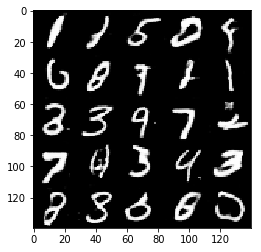

Epoch 2/2... Batch 1610... Discriminator Loss: 0.3916... Generator Loss: 2.8329
Epoch 2/2... Batch 1620... Discriminator Loss: 0.4181... Generator Loss: 3.8445
Epoch 2/2... Batch 1630... Discriminator Loss: 0.3892... Generator Loss: 3.2173
Epoch 2/2... Batch 1640... Discriminator Loss: 0.3873... Generator Loss: 4.3018
Epoch 2/2... Batch 1650... Discriminator Loss: 0.4078... Generator Loss: 2.7154
Epoch 2/2... Batch 1660... Discriminator Loss: 0.4947... Generator Loss: 3.7489
Epoch 2/2... Batch 1670... Discriminator Loss: 0.3667... Generator Loss: 3.9635
Epoch 2/2... Batch 1680... Discriminator Loss: 0.3711... Generator Loss: 3.3889
Epoch 2/2... Batch 1690... Discriminator Loss: 0.3811... Generator Loss: 3.5847
Epoch 2/2... Batch 1700... Discriminator Loss: 0.3609... Generator Loss: 4.7455


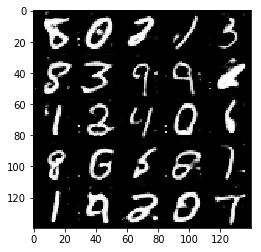

Epoch 2/2... Batch 1710... Discriminator Loss: 0.3887... Generator Loss: 3.8224
Epoch 2/2... Batch 1720... Discriminator Loss: 0.5969... Generator Loss: 2.0767
Epoch 2/2... Batch 1730... Discriminator Loss: 0.3656... Generator Loss: 3.1214
Epoch 2/2... Batch 1740... Discriminator Loss: 0.5507... Generator Loss: 2.4598
Epoch 2/2... Batch 1750... Discriminator Loss: 0.3850... Generator Loss: 3.3581
Epoch 2/2... Batch 1760... Discriminator Loss: 0.3859... Generator Loss: 3.4645
Epoch 2/2... Batch 1770... Discriminator Loss: 1.0310... Generator Loss: 1.6530
Epoch 2/2... Batch 1780... Discriminator Loss: 2.6588... Generator Loss: 7.1233
Epoch 2/2... Batch 1790... Discriminator Loss: 0.3908... Generator Loss: 3.3279
Epoch 2/2... Batch 1800... Discriminator Loss: 0.3984... Generator Loss: 3.6867


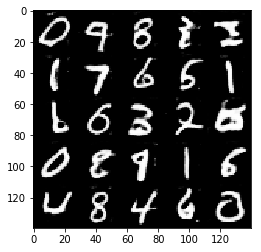

Epoch 2/2... Batch 1810... Discriminator Loss: 0.6900... Generator Loss: 1.9427
Epoch 2/2... Batch 1820... Discriminator Loss: 0.5305... Generator Loss: 3.6468
Epoch 2/2... Batch 1830... Discriminator Loss: 0.5520... Generator Loss: 2.3020
Epoch 2/2... Batch 1840... Discriminator Loss: 0.3720... Generator Loss: 3.5732
Epoch 2/2... Batch 1850... Discriminator Loss: 0.4087... Generator Loss: 3.2531
Epoch 2/2... Batch 1860... Discriminator Loss: 0.4001... Generator Loss: 4.1158
Epoch 2/2... Batch 1870... Discriminator Loss: 0.4103... Generator Loss: 3.0265


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 1.6905... Generator Loss: 7.0749
Epoch 1/1... Batch 20... Discriminator Loss: 1.3087... Generator Loss: 0.9691
Epoch 1/1... Batch 30... Discriminator Loss: 1.1622... Generator Loss: 9.1674
Epoch 1/1... Batch 40... Discriminator Loss: 1.0070... Generator Loss: 0.9538
Epoch 1/1... Batch 50... Discriminator Loss: 0.6669... Generator Loss: 1.7104
Epoch 1/1... Batch 60... Discriminator Loss: 0.4875... Generator Loss: 3.0039
Epoch 1/1... Batch 70... Discriminator Loss: 0.4493... Generator Loss: 2.7212
Epoch 1/1... Batch 80... Discriminator Loss: 0.6415... Generator Loss: 1.7638
Epoch 1/1... Batch 90... Discriminator Loss: 0.6002... Generator Loss: 1.6510
Epoch 1/1... Batch 100... Discriminator Loss: 0.6412... Generator Loss: 4.6149


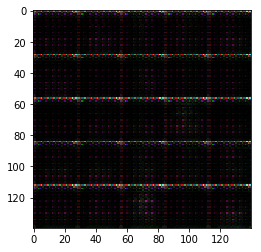

Epoch 1/1... Batch 110... Discriminator Loss: 0.7103... Generator Loss: 1.8082
Epoch 1/1... Batch 120... Discriminator Loss: 1.7808... Generator Loss: 9.1477
Epoch 1/1... Batch 130... Discriminator Loss: 0.4647... Generator Loss: 2.8126
Epoch 1/1... Batch 140... Discriminator Loss: 0.4786... Generator Loss: 2.6299
Epoch 1/1... Batch 150... Discriminator Loss: 0.5148... Generator Loss: 4.2001
Epoch 1/1... Batch 160... Discriminator Loss: 0.5052... Generator Loss: 2.2717
Epoch 1/1... Batch 170... Discriminator Loss: 0.5051... Generator Loss: 2.1122
Epoch 1/1... Batch 180... Discriminator Loss: 0.5078... Generator Loss: 3.2025
Epoch 1/1... Batch 190... Discriminator Loss: 0.4616... Generator Loss: 2.5315
Epoch 1/1... Batch 200... Discriminator Loss: 0.7100... Generator Loss: 1.7742


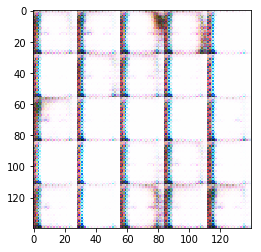

Epoch 1/1... Batch 210... Discriminator Loss: 0.5459... Generator Loss: 3.1116
Epoch 1/1... Batch 220... Discriminator Loss: 0.5296... Generator Loss: 2.3062
Epoch 1/1... Batch 230... Discriminator Loss: 0.5573... Generator Loss: 1.9869
Epoch 1/1... Batch 240... Discriminator Loss: 0.5694... Generator Loss: 1.9516
Epoch 1/1... Batch 250... Discriminator Loss: 0.9183... Generator Loss: 0.9828
Epoch 1/1... Batch 260... Discriminator Loss: 1.2534... Generator Loss: 0.6734
Epoch 1/1... Batch 270... Discriminator Loss: 0.8710... Generator Loss: 3.8942
Epoch 1/1... Batch 280... Discriminator Loss: 0.6134... Generator Loss: 2.9087
Epoch 1/1... Batch 290... Discriminator Loss: 0.6093... Generator Loss: 1.8650
Epoch 1/1... Batch 300... Discriminator Loss: 1.0129... Generator Loss: 4.2387


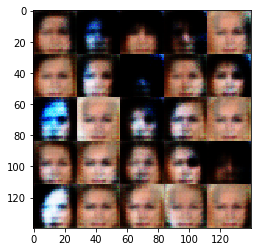

Epoch 1/1... Batch 310... Discriminator Loss: 0.6283... Generator Loss: 1.9003
Epoch 1/1... Batch 320... Discriminator Loss: 1.1571... Generator Loss: 3.2210
Epoch 1/1... Batch 330... Discriminator Loss: 0.8713... Generator Loss: 2.9190
Epoch 1/1... Batch 340... Discriminator Loss: 0.8225... Generator Loss: 2.3701
Epoch 1/1... Batch 350... Discriminator Loss: 0.7125... Generator Loss: 1.3259
Epoch 1/1... Batch 360... Discriminator Loss: 0.9999... Generator Loss: 1.9531
Epoch 1/1... Batch 370... Discriminator Loss: 0.6909... Generator Loss: 1.4728
Epoch 1/1... Batch 380... Discriminator Loss: 0.8242... Generator Loss: 2.5252
Epoch 1/1... Batch 390... Discriminator Loss: 0.7763... Generator Loss: 1.4940
Epoch 1/1... Batch 400... Discriminator Loss: 1.6583... Generator Loss: 0.4360


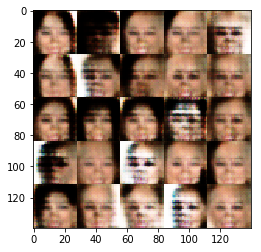

Epoch 1/1... Batch 410... Discriminator Loss: 0.7987... Generator Loss: 1.3169
Epoch 1/1... Batch 420... Discriminator Loss: 0.7773... Generator Loss: 1.4368
Epoch 1/1... Batch 430... Discriminator Loss: 0.7315... Generator Loss: 2.3750
Epoch 1/1... Batch 440... Discriminator Loss: 0.9671... Generator Loss: 0.8825
Epoch 1/1... Batch 450... Discriminator Loss: 0.7698... Generator Loss: 1.8168
Epoch 1/1... Batch 460... Discriminator Loss: 0.9333... Generator Loss: 0.9651
Epoch 1/1... Batch 470... Discriminator Loss: 1.0807... Generator Loss: 0.7546
Epoch 1/1... Batch 480... Discriminator Loss: 0.6760... Generator Loss: 1.8659
Epoch 1/1... Batch 490... Discriminator Loss: 0.8378... Generator Loss: 1.5709
Epoch 1/1... Batch 500... Discriminator Loss: 1.2405... Generator Loss: 0.5544


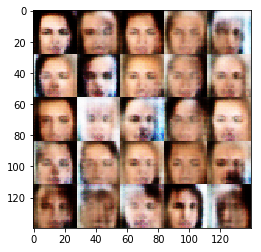

Epoch 1/1... Batch 510... Discriminator Loss: 1.2565... Generator Loss: 0.5966
Epoch 1/1... Batch 520... Discriminator Loss: 1.2517... Generator Loss: 2.9755
Epoch 1/1... Batch 530... Discriminator Loss: 0.7078... Generator Loss: 1.4040
Epoch 1/1... Batch 540... Discriminator Loss: 1.5239... Generator Loss: 3.5358
Epoch 1/1... Batch 550... Discriminator Loss: 0.7381... Generator Loss: 1.4292
Epoch 1/1... Batch 560... Discriminator Loss: 1.2022... Generator Loss: 0.7577
Epoch 1/1... Batch 570... Discriminator Loss: 1.0515... Generator Loss: 0.9524
Epoch 1/1... Batch 580... Discriminator Loss: 1.2632... Generator Loss: 0.5813
Epoch 1/1... Batch 590... Discriminator Loss: 1.9007... Generator Loss: 0.3155
Epoch 1/1... Batch 600... Discriminator Loss: 1.8804... Generator Loss: 0.3127


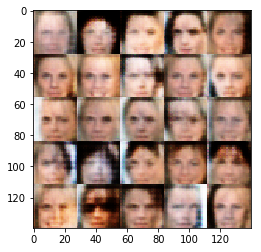

Epoch 1/1... Batch 610... Discriminator Loss: 0.9127... Generator Loss: 1.1367
Epoch 1/1... Batch 620... Discriminator Loss: 1.1082... Generator Loss: 0.8034
Epoch 1/1... Batch 630... Discriminator Loss: 0.7894... Generator Loss: 2.2179
Epoch 1/1... Batch 640... Discriminator Loss: 0.9612... Generator Loss: 1.3206
Epoch 1/1... Batch 650... Discriminator Loss: 0.8889... Generator Loss: 1.3156
Epoch 1/1... Batch 660... Discriminator Loss: 1.3945... Generator Loss: 0.5059
Epoch 1/1... Batch 670... Discriminator Loss: 0.9474... Generator Loss: 2.1939
Epoch 1/1... Batch 680... Discriminator Loss: 1.0694... Generator Loss: 0.7037
Epoch 1/1... Batch 690... Discriminator Loss: 0.8052... Generator Loss: 1.5133
Epoch 1/1... Batch 700... Discriminator Loss: 2.1301... Generator Loss: 0.2351


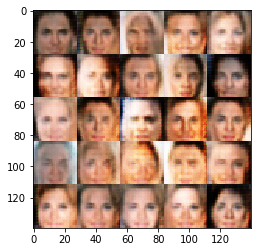

Epoch 1/1... Batch 710... Discriminator Loss: 0.8844... Generator Loss: 1.0605
Epoch 1/1... Batch 720... Discriminator Loss: 0.9607... Generator Loss: 2.0550
Epoch 1/1... Batch 730... Discriminator Loss: 1.5170... Generator Loss: 0.5948
Epoch 1/1... Batch 740... Discriminator Loss: 1.0120... Generator Loss: 1.7392
Epoch 1/1... Batch 750... Discriminator Loss: 1.0235... Generator Loss: 0.7631
Epoch 1/1... Batch 760... Discriminator Loss: 0.6990... Generator Loss: 2.5618
Epoch 1/1... Batch 770... Discriminator Loss: 1.7816... Generator Loss: 3.2633
Epoch 1/1... Batch 780... Discriminator Loss: 1.3418... Generator Loss: 0.4767
Epoch 1/1... Batch 790... Discriminator Loss: 1.1560... Generator Loss: 0.8693
Epoch 1/1... Batch 800... Discriminator Loss: 0.9635... Generator Loss: 0.8929


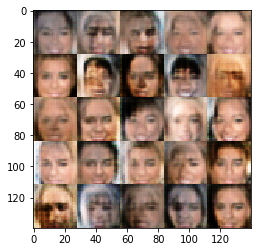

Epoch 1/1... Batch 810... Discriminator Loss: 1.0123... Generator Loss: 1.5399
Epoch 1/1... Batch 820... Discriminator Loss: 1.2368... Generator Loss: 0.7388
Epoch 1/1... Batch 830... Discriminator Loss: 1.0383... Generator Loss: 2.5714
Epoch 1/1... Batch 840... Discriminator Loss: 0.9977... Generator Loss: 1.2323
Epoch 1/1... Batch 850... Discriminator Loss: 0.9392... Generator Loss: 1.3251
Epoch 1/1... Batch 860... Discriminator Loss: 0.8342... Generator Loss: 1.2101
Epoch 1/1... Batch 870... Discriminator Loss: 1.1168... Generator Loss: 0.8029
Epoch 1/1... Batch 880... Discriminator Loss: 0.9979... Generator Loss: 0.9104
Epoch 1/1... Batch 890... Discriminator Loss: 0.5398... Generator Loss: 2.0786
Epoch 1/1... Batch 900... Discriminator Loss: 0.9387... Generator Loss: 1.6868


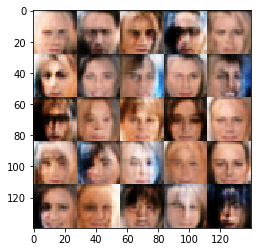

Epoch 1/1... Batch 910... Discriminator Loss: 0.9344... Generator Loss: 1.9009
Epoch 1/1... Batch 920... Discriminator Loss: 1.0277... Generator Loss: 0.7962
Epoch 1/1... Batch 930... Discriminator Loss: 0.7815... Generator Loss: 1.2852
Epoch 1/1... Batch 940... Discriminator Loss: 1.2842... Generator Loss: 0.6288
Epoch 1/1... Batch 950... Discriminator Loss: 0.6091... Generator Loss: 2.2041
Epoch 1/1... Batch 960... Discriminator Loss: 1.5698... Generator Loss: 0.6230
Epoch 1/1... Batch 970... Discriminator Loss: 1.1306... Generator Loss: 0.7979
Epoch 1/1... Batch 980... Discriminator Loss: 0.9445... Generator Loss: 0.8796
Epoch 1/1... Batch 990... Discriminator Loss: 1.6347... Generator Loss: 0.4636
Epoch 1/1... Batch 1000... Discriminator Loss: 0.7632... Generator Loss: 1.4757


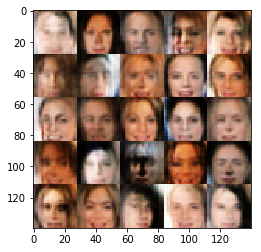

Epoch 1/1... Batch 1010... Discriminator Loss: 0.9723... Generator Loss: 1.4857
Epoch 1/1... Batch 1020... Discriminator Loss: 0.8491... Generator Loss: 1.2679
Epoch 1/1... Batch 1030... Discriminator Loss: 0.7362... Generator Loss: 1.3910
Epoch 1/1... Batch 1040... Discriminator Loss: 1.4613... Generator Loss: 0.5303
Epoch 1/1... Batch 1050... Discriminator Loss: 1.1519... Generator Loss: 0.7108
Epoch 1/1... Batch 1060... Discriminator Loss: 1.0244... Generator Loss: 0.8515
Epoch 1/1... Batch 1070... Discriminator Loss: 1.9087... Generator Loss: 0.2685
Epoch 1/1... Batch 1080... Discriminator Loss: 1.0501... Generator Loss: 0.7324
Epoch 1/1... Batch 1090... Discriminator Loss: 0.9656... Generator Loss: 1.1283
Epoch 1/1... Batch 1100... Discriminator Loss: 0.8391... Generator Loss: 1.3763


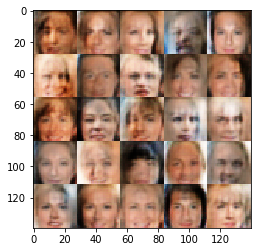

Epoch 1/1... Batch 1110... Discriminator Loss: 0.9017... Generator Loss: 1.6930
Epoch 1/1... Batch 1120... Discriminator Loss: 0.7967... Generator Loss: 1.2073
Epoch 1/1... Batch 1130... Discriminator Loss: 0.7513... Generator Loss: 1.5299
Epoch 1/1... Batch 1140... Discriminator Loss: 0.8932... Generator Loss: 1.0003
Epoch 1/1... Batch 1150... Discriminator Loss: 0.6243... Generator Loss: 1.7465
Epoch 1/1... Batch 1160... Discriminator Loss: 1.2221... Generator Loss: 0.6899
Epoch 1/1... Batch 1170... Discriminator Loss: 1.2588... Generator Loss: 1.7018
Epoch 1/1... Batch 1180... Discriminator Loss: 0.7276... Generator Loss: 1.3969
Epoch 1/1... Batch 1190... Discriminator Loss: 1.0643... Generator Loss: 2.2610
Epoch 1/1... Batch 1200... Discriminator Loss: 0.8538... Generator Loss: 1.1772


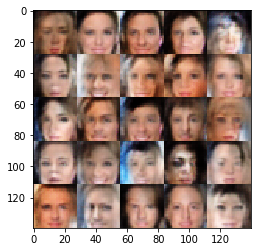

Epoch 1/1... Batch 1210... Discriminator Loss: 1.8732... Generator Loss: 0.4132
Epoch 1/1... Batch 1220... Discriminator Loss: 0.9320... Generator Loss: 1.1676
Epoch 1/1... Batch 1230... Discriminator Loss: 0.9452... Generator Loss: 1.3696
Epoch 1/1... Batch 1240... Discriminator Loss: 1.1999... Generator Loss: 0.7144
Epoch 1/1... Batch 1250... Discriminator Loss: 0.8818... Generator Loss: 1.0972
Epoch 1/1... Batch 1260... Discriminator Loss: 0.7781... Generator Loss: 1.6136
Epoch 1/1... Batch 1270... Discriminator Loss: 1.2589... Generator Loss: 0.5636
Epoch 1/1... Batch 1280... Discriminator Loss: 1.6060... Generator Loss: 0.4451
Epoch 1/1... Batch 1290... Discriminator Loss: 0.9990... Generator Loss: 1.4700
Epoch 1/1... Batch 1300... Discriminator Loss: 1.4151... Generator Loss: 0.6488


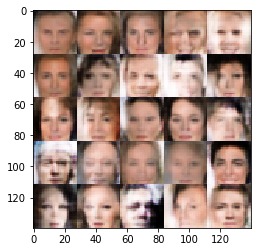

Epoch 1/1... Batch 1310... Discriminator Loss: 0.8643... Generator Loss: 1.2751
Epoch 1/1... Batch 1320... Discriminator Loss: 1.2493... Generator Loss: 0.7104
Epoch 1/1... Batch 1330... Discriminator Loss: 1.0402... Generator Loss: 0.8361
Epoch 1/1... Batch 1340... Discriminator Loss: 1.0891... Generator Loss: 2.3864
Epoch 1/1... Batch 1350... Discriminator Loss: 0.7946... Generator Loss: 1.5685
Epoch 1/1... Batch 1360... Discriminator Loss: 0.9620... Generator Loss: 1.0128
Epoch 1/1... Batch 1370... Discriminator Loss: 0.9367... Generator Loss: 1.3107
Epoch 1/1... Batch 1380... Discriminator Loss: 1.0375... Generator Loss: 0.8550
Epoch 1/1... Batch 1390... Discriminator Loss: 0.8809... Generator Loss: 2.6504
Epoch 1/1... Batch 1400... Discriminator Loss: 1.1739... Generator Loss: 0.7573


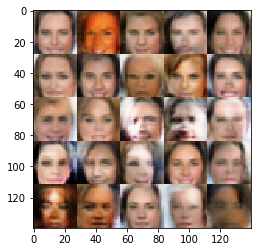

Epoch 1/1... Batch 1410... Discriminator Loss: 1.4252... Generator Loss: 0.6120
Epoch 1/1... Batch 1420... Discriminator Loss: 0.8551... Generator Loss: 1.0686
Epoch 1/1... Batch 1430... Discriminator Loss: 0.8246... Generator Loss: 1.9564
Epoch 1/1... Batch 1440... Discriminator Loss: 1.2797... Generator Loss: 0.6427
Epoch 1/1... Batch 1450... Discriminator Loss: 1.0601... Generator Loss: 0.8326
Epoch 1/1... Batch 1460... Discriminator Loss: 1.0748... Generator Loss: 2.0521
Epoch 1/1... Batch 1470... Discriminator Loss: 0.8115... Generator Loss: 1.4838
Epoch 1/1... Batch 1480... Discriminator Loss: 0.7036... Generator Loss: 2.0671
Epoch 1/1... Batch 1490... Discriminator Loss: 1.4352... Generator Loss: 0.6288
Epoch 1/1... Batch 1500... Discriminator Loss: 2.1587... Generator Loss: 0.2965


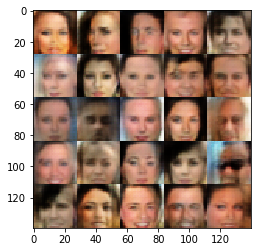

Epoch 1/1... Batch 1510... Discriminator Loss: 0.9448... Generator Loss: 1.3122
Epoch 1/1... Batch 1520... Discriminator Loss: 0.8077... Generator Loss: 1.3500
Epoch 1/1... Batch 1530... Discriminator Loss: 0.8903... Generator Loss: 1.7416
Epoch 1/1... Batch 1540... Discriminator Loss: 2.2371... Generator Loss: 4.0052
Epoch 1/1... Batch 1550... Discriminator Loss: 0.7961... Generator Loss: 1.7734
Epoch 1/1... Batch 1560... Discriminator Loss: 0.8313... Generator Loss: 1.4393
Epoch 1/1... Batch 1570... Discriminator Loss: 0.9001... Generator Loss: 1.9618
Epoch 1/1... Batch 1580... Discriminator Loss: 0.7393... Generator Loss: 1.7151
Epoch 1/1... Batch 1590... Discriminator Loss: 0.9590... Generator Loss: 0.8678
Epoch 1/1... Batch 1600... Discriminator Loss: 0.6384... Generator Loss: 1.7000


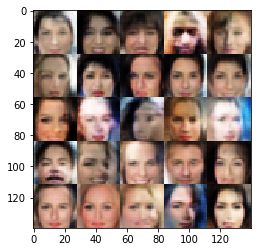

Epoch 1/1... Batch 1610... Discriminator Loss: 0.9562... Generator Loss: 1.0085
Epoch 1/1... Batch 1620... Discriminator Loss: 1.7649... Generator Loss: 3.1089
Epoch 1/1... Batch 1630... Discriminator Loss: 1.0206... Generator Loss: 0.9791
Epoch 1/1... Batch 1640... Discriminator Loss: 1.2096... Generator Loss: 0.6225
Epoch 1/1... Batch 1650... Discriminator Loss: 1.0643... Generator Loss: 0.8150
Epoch 1/1... Batch 1660... Discriminator Loss: 0.8831... Generator Loss: 1.4734
Epoch 1/1... Batch 1670... Discriminator Loss: 0.8245... Generator Loss: 1.3162
Epoch 1/1... Batch 1680... Discriminator Loss: 1.4110... Generator Loss: 0.5483
Epoch 1/1... Batch 1690... Discriminator Loss: 0.7309... Generator Loss: 1.0939
Epoch 1/1... Batch 1700... Discriminator Loss: 0.9210... Generator Loss: 1.9578


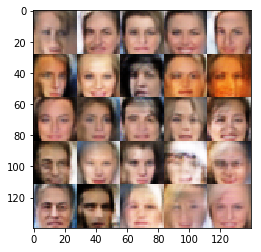

Epoch 1/1... Batch 1710... Discriminator Loss: 1.3005... Generator Loss: 0.7027
Epoch 1/1... Batch 1720... Discriminator Loss: 0.8355... Generator Loss: 1.2688
Epoch 1/1... Batch 1730... Discriminator Loss: 0.6608... Generator Loss: 1.6702
Epoch 1/1... Batch 1740... Discriminator Loss: 0.9318... Generator Loss: 1.0815
Epoch 1/1... Batch 1750... Discriminator Loss: 0.9635... Generator Loss: 0.9289
Epoch 1/1... Batch 1760... Discriminator Loss: 0.7446... Generator Loss: 1.4463
Epoch 1/1... Batch 1770... Discriminator Loss: 0.7333... Generator Loss: 1.8188
Epoch 1/1... Batch 1780... Discriminator Loss: 0.9751... Generator Loss: 3.4058
Epoch 1/1... Batch 1790... Discriminator Loss: 1.1976... Generator Loss: 2.3490
Epoch 1/1... Batch 1800... Discriminator Loss: 0.9324... Generator Loss: 1.8036


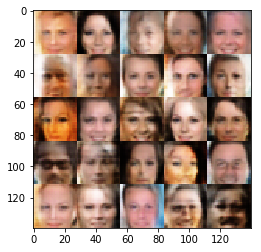

Epoch 1/1... Batch 1810... Discriminator Loss: 0.9740... Generator Loss: 1.6952
Epoch 1/1... Batch 1820... Discriminator Loss: 1.5093... Generator Loss: 0.4387
Epoch 1/1... Batch 1830... Discriminator Loss: 1.0534... Generator Loss: 0.7143
Epoch 1/1... Batch 1840... Discriminator Loss: 0.8794... Generator Loss: 1.1993
Epoch 1/1... Batch 1850... Discriminator Loss: 0.8101... Generator Loss: 1.9833
Epoch 1/1... Batch 1860... Discriminator Loss: 0.7995... Generator Loss: 1.4134
Epoch 1/1... Batch 1870... Discriminator Loss: 0.8968... Generator Loss: 0.9981
Epoch 1/1... Batch 1880... Discriminator Loss: 1.0217... Generator Loss: 1.3748
Epoch 1/1... Batch 1890... Discriminator Loss: 1.2388... Generator Loss: 0.6996
Epoch 1/1... Batch 1900... Discriminator Loss: 1.2364... Generator Loss: 0.7528


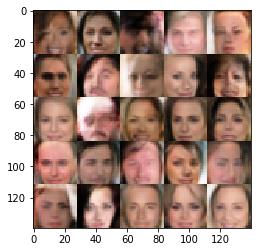

Epoch 1/1... Batch 1910... Discriminator Loss: 0.7696... Generator Loss: 1.4870
Epoch 1/1... Batch 1920... Discriminator Loss: 0.7347... Generator Loss: 1.5484
Epoch 1/1... Batch 1930... Discriminator Loss: 0.6913... Generator Loss: 1.9708
Epoch 1/1... Batch 1940... Discriminator Loss: 1.2614... Generator Loss: 2.4370
Epoch 1/1... Batch 1950... Discriminator Loss: 0.8032... Generator Loss: 1.8182
Epoch 1/1... Batch 1960... Discriminator Loss: 0.8060... Generator Loss: 1.3176
Epoch 1/1... Batch 1970... Discriminator Loss: 0.8792... Generator Loss: 3.0300
Epoch 1/1... Batch 1980... Discriminator Loss: 1.0817... Generator Loss: 0.8204
Epoch 1/1... Batch 1990... Discriminator Loss: 1.0060... Generator Loss: 0.8886
Epoch 1/1... Batch 2000... Discriminator Loss: 0.7669... Generator Loss: 1.4976


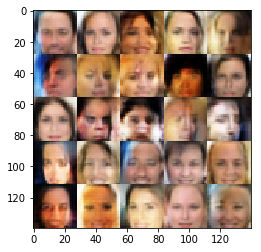

Epoch 1/1... Batch 2010... Discriminator Loss: 0.8084... Generator Loss: 1.4936
Epoch 1/1... Batch 2020... Discriminator Loss: 1.2955... Generator Loss: 0.6611
Epoch 1/1... Batch 2030... Discriminator Loss: 0.7468... Generator Loss: 1.2503
Epoch 1/1... Batch 2040... Discriminator Loss: 0.8113... Generator Loss: 1.6095
Epoch 1/1... Batch 2050... Discriminator Loss: 0.7313... Generator Loss: 1.3487
Epoch 1/1... Batch 2060... Discriminator Loss: 0.7011... Generator Loss: 2.7370
Epoch 1/1... Batch 2070... Discriminator Loss: 0.8161... Generator Loss: 1.6998
Epoch 1/1... Batch 2080... Discriminator Loss: 1.0168... Generator Loss: 0.9094
Epoch 1/1... Batch 2090... Discriminator Loss: 0.6609... Generator Loss: 1.4484
Epoch 1/1... Batch 2100... Discriminator Loss: 1.3428... Generator Loss: 0.5503


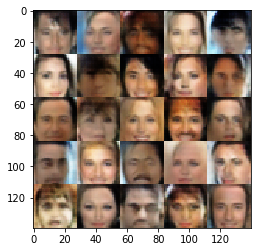

Epoch 1/1... Batch 2110... Discriminator Loss: 0.6987... Generator Loss: 1.4949
Epoch 1/1... Batch 2120... Discriminator Loss: 0.9356... Generator Loss: 0.9223
Epoch 1/1... Batch 2130... Discriminator Loss: 0.9080... Generator Loss: 1.1685
Epoch 1/1... Batch 2140... Discriminator Loss: 1.1408... Generator Loss: 0.7054
Epoch 1/1... Batch 2150... Discriminator Loss: 0.8075... Generator Loss: 1.2666
Epoch 1/1... Batch 2160... Discriminator Loss: 0.7971... Generator Loss: 1.5059
Epoch 1/1... Batch 2170... Discriminator Loss: 0.7543... Generator Loss: 1.6195
Epoch 1/1... Batch 2180... Discriminator Loss: 0.8699... Generator Loss: 2.8072
Epoch 1/1... Batch 2190... Discriminator Loss: 0.8974... Generator Loss: 0.9508
Epoch 1/1... Batch 2200... Discriminator Loss: 1.5754... Generator Loss: 0.4769


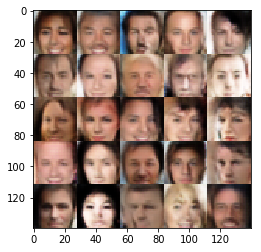

Epoch 1/1... Batch 2210... Discriminator Loss: 0.8754... Generator Loss: 1.3524
Epoch 1/1... Batch 2220... Discriminator Loss: 0.9331... Generator Loss: 0.9042
Epoch 1/1... Batch 2230... Discriminator Loss: 1.4066... Generator Loss: 0.4362
Epoch 1/1... Batch 2240... Discriminator Loss: 0.8816... Generator Loss: 2.6746
Epoch 1/1... Batch 2250... Discriminator Loss: 0.7019... Generator Loss: 2.5257
Epoch 1/1... Batch 2260... Discriminator Loss: 2.0212... Generator Loss: 4.1182
Epoch 1/1... Batch 2270... Discriminator Loss: 0.9496... Generator Loss: 1.3346
Epoch 1/1... Batch 2280... Discriminator Loss: 1.0110... Generator Loss: 0.9314
Epoch 1/1... Batch 2290... Discriminator Loss: 0.7293... Generator Loss: 1.5307
Epoch 1/1... Batch 2300... Discriminator Loss: 0.8250... Generator Loss: 1.1173


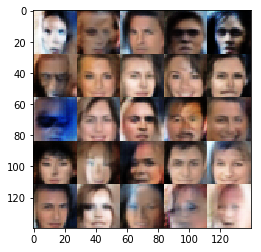

Epoch 1/1... Batch 2310... Discriminator Loss: 1.4430... Generator Loss: 0.3871
Epoch 1/1... Batch 2320... Discriminator Loss: 0.7827... Generator Loss: 1.6614
Epoch 1/1... Batch 2330... Discriminator Loss: 0.8182... Generator Loss: 2.3038
Epoch 1/1... Batch 2340... Discriminator Loss: 0.5925... Generator Loss: 1.9768
Epoch 1/1... Batch 2350... Discriminator Loss: 0.7663... Generator Loss: 1.6827
Epoch 1/1... Batch 2360... Discriminator Loss: 0.5903... Generator Loss: 2.1362
Epoch 1/1... Batch 2370... Discriminator Loss: 0.8622... Generator Loss: 1.3890
Epoch 1/1... Batch 2380... Discriminator Loss: 0.8429... Generator Loss: 1.6237
Epoch 1/1... Batch 2390... Discriminator Loss: 1.3138... Generator Loss: 0.6170
Epoch 1/1... Batch 2400... Discriminator Loss: 1.5893... Generator Loss: 0.4904


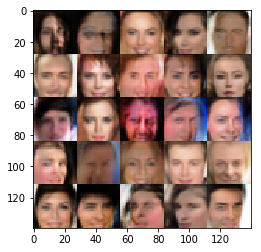

Epoch 1/1... Batch 2410... Discriminator Loss: 0.7863... Generator Loss: 3.9039
Epoch 1/1... Batch 2420... Discriminator Loss: 0.6575... Generator Loss: 1.5273
Epoch 1/1... Batch 2430... Discriminator Loss: 0.7680... Generator Loss: 2.1439
Epoch 1/1... Batch 2440... Discriminator Loss: 0.7141... Generator Loss: 2.4530
Epoch 1/1... Batch 2450... Discriminator Loss: 1.0183... Generator Loss: 0.8421
Epoch 1/1... Batch 2460... Discriminator Loss: 0.8744... Generator Loss: 2.6945
Epoch 1/1... Batch 2470... Discriminator Loss: 1.0333... Generator Loss: 3.0621
Epoch 1/1... Batch 2480... Discriminator Loss: 0.5374... Generator Loss: 2.4422
Epoch 1/1... Batch 2490... Discriminator Loss: 0.5707... Generator Loss: 1.7861
Epoch 1/1... Batch 2500... Discriminator Loss: 0.8363... Generator Loss: 1.1731


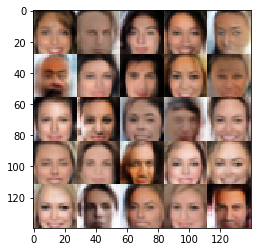

Epoch 1/1... Batch 2510... Discriminator Loss: 0.4809... Generator Loss: 2.4634
Epoch 1/1... Batch 2520... Discriminator Loss: 0.3693... Generator Loss: 3.5118
Epoch 1/1... Batch 2530... Discriminator Loss: 1.8465... Generator Loss: 2.5779
Epoch 1/1... Batch 2540... Discriminator Loss: 0.8122... Generator Loss: 1.2238
Epoch 1/1... Batch 2550... Discriminator Loss: 0.8692... Generator Loss: 1.2232
Epoch 1/1... Batch 2560... Discriminator Loss: 0.8880... Generator Loss: 0.9317
Epoch 1/1... Batch 2570... Discriminator Loss: 0.8093... Generator Loss: 1.3392
Epoch 1/1... Batch 2580... Discriminator Loss: 0.7297... Generator Loss: 1.3547
Epoch 1/1... Batch 2590... Discriminator Loss: 0.7650... Generator Loss: 1.7369
Epoch 1/1... Batch 2600... Discriminator Loss: 0.7028... Generator Loss: 1.9359


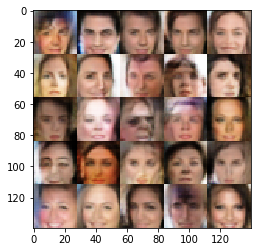

Epoch 1/1... Batch 2610... Discriminator Loss: 1.0224... Generator Loss: 0.8044
Epoch 1/1... Batch 2620... Discriminator Loss: 0.5754... Generator Loss: 3.3768
Epoch 1/1... Batch 2630... Discriminator Loss: 0.7551... Generator Loss: 1.6186
Epoch 1/1... Batch 2640... Discriminator Loss: 0.8790... Generator Loss: 3.1748
Epoch 1/1... Batch 2650... Discriminator Loss: 0.6927... Generator Loss: 1.8620
Epoch 1/1... Batch 2660... Discriminator Loss: 0.8922... Generator Loss: 1.6592
Epoch 1/1... Batch 2670... Discriminator Loss: 1.2372... Generator Loss: 0.8233
Epoch 1/1... Batch 2680... Discriminator Loss: 0.7459... Generator Loss: 1.2601
Epoch 1/1... Batch 2690... Discriminator Loss: 0.8712... Generator Loss: 1.3003
Epoch 1/1... Batch 2700... Discriminator Loss: 0.9512... Generator Loss: 0.9761


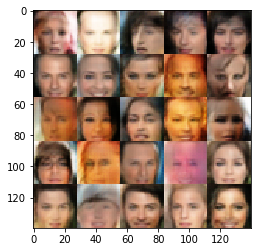

Epoch 1/1... Batch 2710... Discriminator Loss: 0.7438... Generator Loss: 3.3705
Epoch 1/1... Batch 2720... Discriminator Loss: 0.4808... Generator Loss: 2.7743
Epoch 1/1... Batch 2730... Discriminator Loss: 1.5186... Generator Loss: 0.6447
Epoch 1/1... Batch 2740... Discriminator Loss: 0.6147... Generator Loss: 1.7940
Epoch 1/1... Batch 2750... Discriminator Loss: 0.6137... Generator Loss: 2.2563
Epoch 1/1... Batch 2760... Discriminator Loss: 1.4089... Generator Loss: 0.6973
Epoch 1/1... Batch 2770... Discriminator Loss: 0.8786... Generator Loss: 1.4353
Epoch 1/1... Batch 2780... Discriminator Loss: 1.3312... Generator Loss: 0.6221
Epoch 1/1... Batch 2790... Discriminator Loss: 1.0180... Generator Loss: 1.1114
Epoch 1/1... Batch 2800... Discriminator Loss: 0.7963... Generator Loss: 1.4560


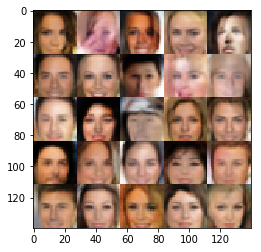

Epoch 1/1... Batch 2810... Discriminator Loss: 1.6633... Generator Loss: 0.5388
Epoch 1/1... Batch 2820... Discriminator Loss: 0.9509... Generator Loss: 0.8782
Epoch 1/1... Batch 2830... Discriminator Loss: 0.9739... Generator Loss: 2.1404
Epoch 1/1... Batch 2840... Discriminator Loss: 0.7868... Generator Loss: 1.2536
Epoch 1/1... Batch 2850... Discriminator Loss: 0.5433... Generator Loss: 2.2508
Epoch 1/1... Batch 2860... Discriminator Loss: 1.3743... Generator Loss: 1.5163
Epoch 1/1... Batch 2870... Discriminator Loss: 0.8105... Generator Loss: 1.1459
Epoch 1/1... Batch 2880... Discriminator Loss: 0.5119... Generator Loss: 2.6205
Epoch 1/1... Batch 2890... Discriminator Loss: 0.5766... Generator Loss: 1.7707
Epoch 1/1... Batch 2900... Discriminator Loss: 0.8785... Generator Loss: 1.1881


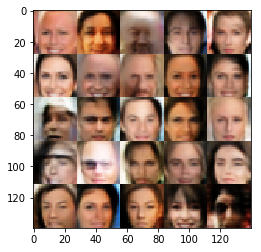

Epoch 1/1... Batch 2910... Discriminator Loss: 0.7952... Generator Loss: 2.4243
Epoch 1/1... Batch 2920... Discriminator Loss: 1.1480... Generator Loss: 0.7165
Epoch 1/1... Batch 2930... Discriminator Loss: 0.7258... Generator Loss: 1.3473
Epoch 1/1... Batch 2940... Discriminator Loss: 0.7510... Generator Loss: 1.1438
Epoch 1/1... Batch 2950... Discriminator Loss: 0.8111... Generator Loss: 1.2220
Epoch 1/1... Batch 2960... Discriminator Loss: 0.5190... Generator Loss: 2.0361
Epoch 1/1... Batch 2970... Discriminator Loss: 0.5018... Generator Loss: 2.6011
Epoch 1/1... Batch 2980... Discriminator Loss: 1.2796... Generator Loss: 2.4654
Epoch 1/1... Batch 2990... Discriminator Loss: 0.8936... Generator Loss: 1.2843
Epoch 1/1... Batch 3000... Discriminator Loss: 0.6991... Generator Loss: 1.9627


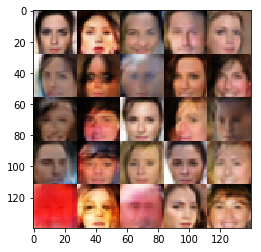

Epoch 1/1... Batch 3010... Discriminator Loss: 0.6602... Generator Loss: 1.2408
Epoch 1/1... Batch 3020... Discriminator Loss: 0.7559... Generator Loss: 1.2678
Epoch 1/1... Batch 3030... Discriminator Loss: 0.6381... Generator Loss: 1.6655
Epoch 1/1... Batch 3040... Discriminator Loss: 0.4857... Generator Loss: 2.7832
Epoch 1/1... Batch 3050... Discriminator Loss: 0.8005... Generator Loss: 3.1862
Epoch 1/1... Batch 3060... Discriminator Loss: 0.7939... Generator Loss: 2.5591
Epoch 1/1... Batch 3070... Discriminator Loss: 0.4549... Generator Loss: 2.6097
Epoch 1/1... Batch 3080... Discriminator Loss: 0.9569... Generator Loss: 1.0287
Epoch 1/1... Batch 3090... Discriminator Loss: 0.7476... Generator Loss: 1.5390
Epoch 1/1... Batch 3100... Discriminator Loss: 1.0653... Generator Loss: 0.7071


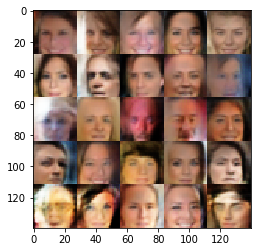

Epoch 1/1... Batch 3110... Discriminator Loss: 0.8308... Generator Loss: 1.2425
Epoch 1/1... Batch 3120... Discriminator Loss: 0.6218... Generator Loss: 1.4986
Epoch 1/1... Batch 3130... Discriminator Loss: 0.8086... Generator Loss: 1.1767
Epoch 1/1... Batch 3140... Discriminator Loss: 0.9419... Generator Loss: 1.0795
Epoch 1/1... Batch 3150... Discriminator Loss: 0.6286... Generator Loss: 1.4679
Epoch 1/1... Batch 3160... Discriminator Loss: 0.9512... Generator Loss: 3.1682
Epoch 1/1... Batch 3170... Discriminator Loss: 1.1916... Generator Loss: 0.7755
Epoch 1/1... Batch 3180... Discriminator Loss: 0.8322... Generator Loss: 1.3613
Epoch 1/1... Batch 3190... Discriminator Loss: 0.8593... Generator Loss: 1.2195
Epoch 1/1... Batch 3200... Discriminator Loss: 0.4540... Generator Loss: 2.2474


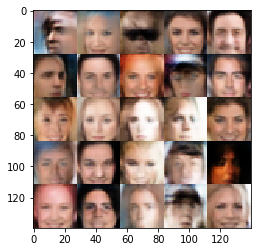

Epoch 1/1... Batch 3210... Discriminator Loss: 1.1185... Generator Loss: 0.7906
Epoch 1/1... Batch 3220... Discriminator Loss: 1.0503... Generator Loss: 0.8010
Epoch 1/1... Batch 3230... Discriminator Loss: 1.1060... Generator Loss: 0.7908
Epoch 1/1... Batch 3240... Discriminator Loss: 0.6334... Generator Loss: 4.0554
Epoch 1/1... Batch 3250... Discriminator Loss: 1.1491... Generator Loss: 0.8628
Epoch 1/1... Batch 3260... Discriminator Loss: 0.5804... Generator Loss: 2.3715
Epoch 1/1... Batch 3270... Discriminator Loss: 0.6697... Generator Loss: 1.4547
Epoch 1/1... Batch 3280... Discriminator Loss: 0.5472... Generator Loss: 2.0005
Epoch 1/1... Batch 3290... Discriminator Loss: 0.6033... Generator Loss: 3.6197
Epoch 1/1... Batch 3300... Discriminator Loss: 0.7072... Generator Loss: 1.4666


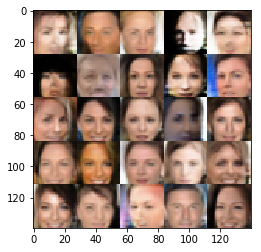

Epoch 1/1... Batch 3310... Discriminator Loss: 0.8876... Generator Loss: 1.2198
Epoch 1/1... Batch 3320... Discriminator Loss: 0.6468... Generator Loss: 1.6411
Epoch 1/1... Batch 3330... Discriminator Loss: 0.6632... Generator Loss: 3.3218
Epoch 1/1... Batch 3340... Discriminator Loss: 0.6257... Generator Loss: 1.7777
Epoch 1/1... Batch 3350... Discriminator Loss: 0.7507... Generator Loss: 1.6224
Epoch 1/1... Batch 3360... Discriminator Loss: 0.6448... Generator Loss: 1.7592
Epoch 1/1... Batch 3370... Discriminator Loss: 1.0643... Generator Loss: 0.9265
Epoch 1/1... Batch 3380... Discriminator Loss: 0.4127... Generator Loss: 3.5491
Epoch 1/1... Batch 3390... Discriminator Loss: 0.5614... Generator Loss: 2.1555
Epoch 1/1... Batch 3400... Discriminator Loss: 0.5299... Generator Loss: 2.0944


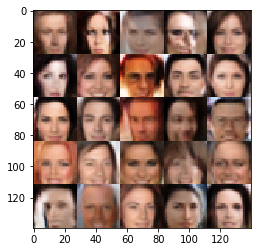

Epoch 1/1... Batch 3410... Discriminator Loss: 1.1641... Generator Loss: 0.8404
Epoch 1/1... Batch 3420... Discriminator Loss: 0.8662... Generator Loss: 1.1308
Epoch 1/1... Batch 3430... Discriminator Loss: 0.6362... Generator Loss: 1.4535
Epoch 1/1... Batch 3440... Discriminator Loss: 0.4853... Generator Loss: 2.7239
Epoch 1/1... Batch 3450... Discriminator Loss: 1.2308... Generator Loss: 0.8418
Epoch 1/1... Batch 3460... Discriminator Loss: 0.6082... Generator Loss: 3.6407
Epoch 1/1... Batch 3470... Discriminator Loss: 0.4890... Generator Loss: 2.1092
Epoch 1/1... Batch 3480... Discriminator Loss: 1.5630... Generator Loss: 3.3292
Epoch 1/1... Batch 3490... Discriminator Loss: 0.6295... Generator Loss: 1.6842
Epoch 1/1... Batch 3500... Discriminator Loss: 0.8098... Generator Loss: 1.4141


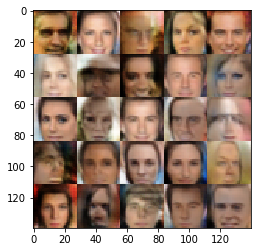

Epoch 1/1... Batch 3510... Discriminator Loss: 0.4532... Generator Loss: 2.5658
Epoch 1/1... Batch 3520... Discriminator Loss: 1.9214... Generator Loss: 0.4044
Epoch 1/1... Batch 3530... Discriminator Loss: 0.7418... Generator Loss: 1.5083
Epoch 1/1... Batch 3540... Discriminator Loss: 0.8878... Generator Loss: 0.9561
Epoch 1/1... Batch 3550... Discriminator Loss: 1.7720... Generator Loss: 4.5565
Epoch 1/1... Batch 3560... Discriminator Loss: 0.7004... Generator Loss: 1.7660
Epoch 1/1... Batch 3570... Discriminator Loss: 0.7458... Generator Loss: 1.1914
Epoch 1/1... Batch 3580... Discriminator Loss: 0.9821... Generator Loss: 0.8055
Epoch 1/1... Batch 3590... Discriminator Loss: 1.0312... Generator Loss: 2.9450
Epoch 1/1... Batch 3600... Discriminator Loss: 0.5428... Generator Loss: 3.1874


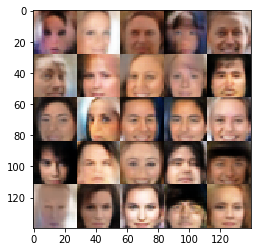

Epoch 1/1... Batch 3610... Discriminator Loss: 1.1272... Generator Loss: 0.8750
Epoch 1/1... Batch 3620... Discriminator Loss: 1.1166... Generator Loss: 0.7972
Epoch 1/1... Batch 3630... Discriminator Loss: 0.7831... Generator Loss: 1.6475
Epoch 1/1... Batch 3640... Discriminator Loss: 0.4905... Generator Loss: 2.7663
Epoch 1/1... Batch 3650... Discriminator Loss: 1.6249... Generator Loss: 0.5881
Epoch 1/1... Batch 3660... Discriminator Loss: 0.6605... Generator Loss: 3.2096
Epoch 1/1... Batch 3670... Discriminator Loss: 0.5850... Generator Loss: 1.8906
Epoch 1/1... Batch 3680... Discriminator Loss: 0.5854... Generator Loss: 3.2786
Epoch 1/1... Batch 3690... Discriminator Loss: 0.9315... Generator Loss: 1.0985
Epoch 1/1... Batch 3700... Discriminator Loss: 0.6815... Generator Loss: 1.5884


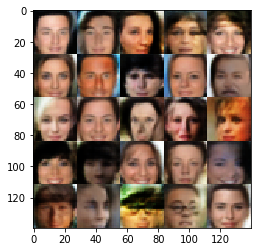

Epoch 1/1... Batch 3710... Discriminator Loss: 0.5702... Generator Loss: 1.8519
Epoch 1/1... Batch 3720... Discriminator Loss: 0.5090... Generator Loss: 4.2049
Epoch 1/1... Batch 3730... Discriminator Loss: 1.0955... Generator Loss: 0.8616
Epoch 1/1... Batch 3740... Discriminator Loss: 1.0865... Generator Loss: 1.0295
Epoch 1/1... Batch 3750... Discriminator Loss: 1.5972... Generator Loss: 0.5606
Epoch 1/1... Batch 3760... Discriminator Loss: 0.5829... Generator Loss: 2.5102
Epoch 1/1... Batch 3770... Discriminator Loss: 0.4478... Generator Loss: 2.8469
Epoch 1/1... Batch 3780... Discriminator Loss: 0.5920... Generator Loss: 1.7808
Epoch 1/1... Batch 3790... Discriminator Loss: 0.9355... Generator Loss: 0.9615
Epoch 1/1... Batch 3800... Discriminator Loss: 0.5013... Generator Loss: 2.2787


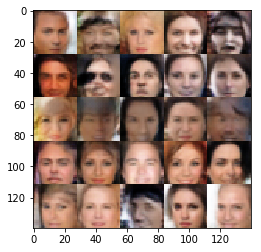

Epoch 1/1... Batch 3810... Discriminator Loss: 0.7689... Generator Loss: 1.4160
Epoch 1/1... Batch 3820... Discriminator Loss: 0.5112... Generator Loss: 2.5126
Epoch 1/1... Batch 3830... Discriminator Loss: 0.9042... Generator Loss: 3.7090
Epoch 1/1... Batch 3840... Discriminator Loss: 0.6250... Generator Loss: 3.1252
Epoch 1/1... Batch 3850... Discriminator Loss: 0.5538... Generator Loss: 2.5037
Epoch 1/1... Batch 3860... Discriminator Loss: 0.4376... Generator Loss: 3.1118
Epoch 1/1... Batch 3870... Discriminator Loss: 0.6297... Generator Loss: 1.3276
Epoch 1/1... Batch 3880... Discriminator Loss: 0.5941... Generator Loss: 1.5229
Epoch 1/1... Batch 3890... Discriminator Loss: 0.8450... Generator Loss: 1.2171
Epoch 1/1... Batch 3900... Discriminator Loss: 0.8309... Generator Loss: 1.1620


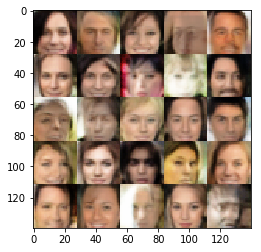

Epoch 1/1... Batch 3910... Discriminator Loss: 1.0097... Generator Loss: 0.8510
Epoch 1/1... Batch 3920... Discriminator Loss: 0.5874... Generator Loss: 2.0715
Epoch 1/1... Batch 3930... Discriminator Loss: 0.4840... Generator Loss: 2.3744
Epoch 1/1... Batch 3940... Discriminator Loss: 0.5530... Generator Loss: 2.7077
Epoch 1/1... Batch 3950... Discriminator Loss: 0.7187... Generator Loss: 1.1766
Epoch 1/1... Batch 3960... Discriminator Loss: 0.6138... Generator Loss: 2.5596
Epoch 1/1... Batch 3970... Discriminator Loss: 0.4701... Generator Loss: 2.5805
Epoch 1/1... Batch 3980... Discriminator Loss: 1.1091... Generator Loss: 0.8247
Epoch 1/1... Batch 3990... Discriminator Loss: 0.5895... Generator Loss: 1.9929
Epoch 1/1... Batch 4000... Discriminator Loss: 1.0670... Generator Loss: 3.2056


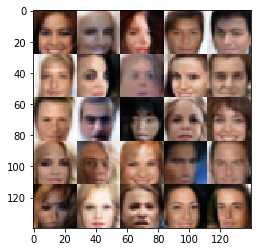

Epoch 1/1... Batch 4010... Discriminator Loss: 0.5205... Generator Loss: 1.9641
Epoch 1/1... Batch 4020... Discriminator Loss: 0.5446... Generator Loss: 2.2492
Epoch 1/1... Batch 4030... Discriminator Loss: 1.1463... Generator Loss: 0.9705
Epoch 1/1... Batch 4040... Discriminator Loss: 0.4853... Generator Loss: 2.8658
Epoch 1/1... Batch 4050... Discriminator Loss: 0.6219... Generator Loss: 2.1005
Epoch 1/1... Batch 4060... Discriminator Loss: 0.7539... Generator Loss: 1.3287
Epoch 1/1... Batch 4070... Discriminator Loss: 0.4362... Generator Loss: 2.6706
Epoch 1/1... Batch 4080... Discriminator Loss: 0.6713... Generator Loss: 1.9929
Epoch 1/1... Batch 4090... Discriminator Loss: 0.6055... Generator Loss: 1.9102
Epoch 1/1... Batch 4100... Discriminator Loss: 0.6787... Generator Loss: 1.5979


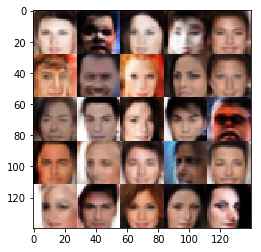

Epoch 1/1... Batch 4110... Discriminator Loss: 0.6737... Generator Loss: 1.5825
Epoch 1/1... Batch 4120... Discriminator Loss: 0.4094... Generator Loss: 3.5865
Epoch 1/1... Batch 4130... Discriminator Loss: 0.7927... Generator Loss: 2.5223
Epoch 1/1... Batch 4140... Discriminator Loss: 0.6757... Generator Loss: 2.1665
Epoch 1/1... Batch 4150... Discriminator Loss: 0.5230... Generator Loss: 2.3597
Epoch 1/1... Batch 4160... Discriminator Loss: 0.8675... Generator Loss: 1.2927
Epoch 1/1... Batch 4170... Discriminator Loss: 0.6186... Generator Loss: 1.5265
Epoch 1/1... Batch 4180... Discriminator Loss: 0.3908... Generator Loss: 3.4722
Epoch 1/1... Batch 4190... Discriminator Loss: 0.4715... Generator Loss: 3.7789
Epoch 1/1... Batch 4200... Discriminator Loss: 0.4462... Generator Loss: 2.4373


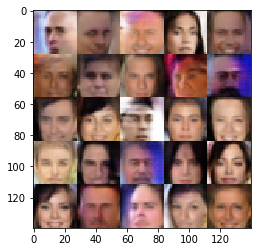

Epoch 1/1... Batch 4210... Discriminator Loss: 0.9055... Generator Loss: 1.0732
Epoch 1/1... Batch 4220... Discriminator Loss: 0.8773... Generator Loss: 1.6608
Epoch 1/1... Batch 4230... Discriminator Loss: 0.5559... Generator Loss: 1.8462
Epoch 1/1... Batch 4240... Discriminator Loss: 0.5455... Generator Loss: 1.9935
Epoch 1/1... Batch 4250... Discriminator Loss: 0.7384... Generator Loss: 1.2862
Epoch 1/1... Batch 4260... Discriminator Loss: 0.6035... Generator Loss: 1.8782
Epoch 1/1... Batch 4270... Discriminator Loss: 0.3787... Generator Loss: 3.4512
Epoch 1/1... Batch 4280... Discriminator Loss: 0.4879... Generator Loss: 2.4548
Epoch 1/1... Batch 4290... Discriminator Loss: 0.5648... Generator Loss: 2.2048
Epoch 1/1... Batch 4300... Discriminator Loss: 1.1567... Generator Loss: 0.9198


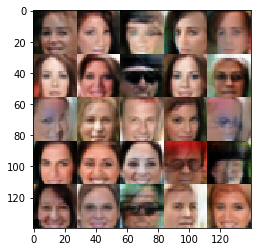

Epoch 1/1... Batch 4310... Discriminator Loss: 0.6683... Generator Loss: 1.9533
Epoch 1/1... Batch 4320... Discriminator Loss: 0.8225... Generator Loss: 1.3537
Epoch 1/1... Batch 4330... Discriminator Loss: 0.9213... Generator Loss: 3.2091
Epoch 1/1... Batch 4340... Discriminator Loss: 0.6957... Generator Loss: 2.5463
Epoch 1/1... Batch 4350... Discriminator Loss: 0.6946... Generator Loss: 1.7508
Epoch 1/1... Batch 4360... Discriminator Loss: 0.7283... Generator Loss: 1.1553
Epoch 1/1... Batch 4370... Discriminator Loss: 0.5819... Generator Loss: 2.4221
Epoch 1/1... Batch 4380... Discriminator Loss: 1.0798... Generator Loss: 2.5968
Epoch 1/1... Batch 4390... Discriminator Loss: 0.8410... Generator Loss: 1.2249
Epoch 1/1... Batch 4400... Discriminator Loss: 0.7735... Generator Loss: 1.4079


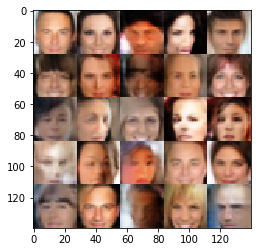

Epoch 1/1... Batch 4410... Discriminator Loss: 0.7308... Generator Loss: 1.6137
Epoch 1/1... Batch 4420... Discriminator Loss: 0.5383... Generator Loss: 2.0318
Epoch 1/1... Batch 4430... Discriminator Loss: 0.9573... Generator Loss: 1.1574
Epoch 1/1... Batch 4440... Discriminator Loss: 0.5849... Generator Loss: 2.2433
Epoch 1/1... Batch 4450... Discriminator Loss: 2.8641... Generator Loss: 5.0726
Epoch 1/1... Batch 4460... Discriminator Loss: 0.6519... Generator Loss: 2.2580
Epoch 1/1... Batch 4470... Discriminator Loss: 0.8844... Generator Loss: 2.7943
Epoch 1/1... Batch 4480... Discriminator Loss: 0.4378... Generator Loss: 3.0707
Epoch 1/1... Batch 4490... Discriminator Loss: 0.9580... Generator Loss: 1.6784
Epoch 1/1... Batch 4500... Discriminator Loss: 0.8103... Generator Loss: 1.0585


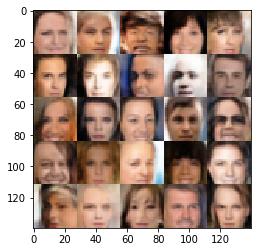

Epoch 1/1... Batch 4510... Discriminator Loss: 0.4893... Generator Loss: 2.2502
Epoch 1/1... Batch 4520... Discriminator Loss: 0.5840... Generator Loss: 1.8272
Epoch 1/1... Batch 4530... Discriminator Loss: 0.9282... Generator Loss: 2.0522
Epoch 1/1... Batch 4540... Discriminator Loss: 0.3827... Generator Loss: 3.5130
Epoch 1/1... Batch 4550... Discriminator Loss: 0.5066... Generator Loss: 3.4537
Epoch 1/1... Batch 4560... Discriminator Loss: 0.6609... Generator Loss: 1.7709
Epoch 1/1... Batch 4570... Discriminator Loss: 0.5342... Generator Loss: 2.1458
Epoch 1/1... Batch 4580... Discriminator Loss: 0.3851... Generator Loss: 3.8728
Epoch 1/1... Batch 4590... Discriminator Loss: 0.6179... Generator Loss: 2.0349
Epoch 1/1... Batch 4600... Discriminator Loss: 0.7979... Generator Loss: 1.9375


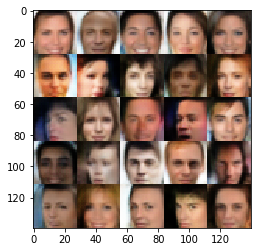

Epoch 1/1... Batch 4610... Discriminator Loss: 0.5218... Generator Loss: 2.6559
Epoch 1/1... Batch 4620... Discriminator Loss: 0.5671... Generator Loss: 2.2183
Epoch 1/1... Batch 4630... Discriminator Loss: 0.4383... Generator Loss: 2.9827
Epoch 1/1... Batch 4640... Discriminator Loss: 0.5160... Generator Loss: 2.9206
Epoch 1/1... Batch 4650... Discriminator Loss: 2.2499... Generator Loss: 0.3437
Epoch 1/1... Batch 4660... Discriminator Loss: 0.5704... Generator Loss: 2.0030
Epoch 1/1... Batch 4670... Discriminator Loss: 0.6308... Generator Loss: 1.4897
Epoch 1/1... Batch 4680... Discriminator Loss: 0.5304... Generator Loss: 2.3485
Epoch 1/1... Batch 4690... Discriminator Loss: 0.4446... Generator Loss: 2.3283
Epoch 1/1... Batch 4700... Discriminator Loss: 0.3935... Generator Loss: 3.2039


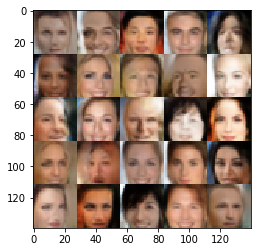

Epoch 1/1... Batch 4710... Discriminator Loss: 0.3982... Generator Loss: 3.5222
Epoch 1/1... Batch 4720... Discriminator Loss: 2.1791... Generator Loss: 6.2371
Epoch 1/1... Batch 4730... Discriminator Loss: 0.6322... Generator Loss: 2.9148
Epoch 1/1... Batch 4740... Discriminator Loss: 0.7074... Generator Loss: 3.0515
Epoch 1/1... Batch 4750... Discriminator Loss: 0.8495... Generator Loss: 1.2101
Epoch 1/1... Batch 4760... Discriminator Loss: 0.6462... Generator Loss: 1.5919
Epoch 1/1... Batch 4770... Discriminator Loss: 0.8551... Generator Loss: 1.2032
Epoch 1/1... Batch 4780... Discriminator Loss: 0.7760... Generator Loss: 3.6375
Epoch 1/1... Batch 4790... Discriminator Loss: 0.8004... Generator Loss: 1.2052
Epoch 1/1... Batch 4800... Discriminator Loss: 0.7332... Generator Loss: 2.6836


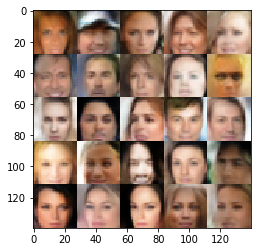

Epoch 1/1... Batch 4810... Discriminator Loss: 0.4240... Generator Loss: 2.9485
Epoch 1/1... Batch 4820... Discriminator Loss: 0.8393... Generator Loss: 1.0967
Epoch 1/1... Batch 4830... Discriminator Loss: 1.4715... Generator Loss: 3.6469
Epoch 1/1... Batch 4840... Discriminator Loss: 0.4512... Generator Loss: 2.9670
Epoch 1/1... Batch 4850... Discriminator Loss: 0.4076... Generator Loss: 3.4636
Epoch 1/1... Batch 4860... Discriminator Loss: 0.4546... Generator Loss: 2.9473
Epoch 1/1... Batch 4870... Discriminator Loss: 1.6202... Generator Loss: 3.9774
Epoch 1/1... Batch 4880... Discriminator Loss: 0.8101... Generator Loss: 1.2643
Epoch 1/1... Batch 4890... Discriminator Loss: 0.5802... Generator Loss: 3.0728
Epoch 1/1... Batch 4900... Discriminator Loss: 0.5216... Generator Loss: 2.7094


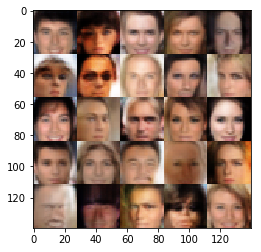

Epoch 1/1... Batch 4910... Discriminator Loss: 0.9771... Generator Loss: 0.8501
Epoch 1/1... Batch 4920... Discriminator Loss: 1.0186... Generator Loss: 1.0037
Epoch 1/1... Batch 4930... Discriminator Loss: 0.4473... Generator Loss: 3.1713
Epoch 1/1... Batch 4940... Discriminator Loss: 0.4734... Generator Loss: 3.4397
Epoch 1/1... Batch 4950... Discriminator Loss: 1.5128... Generator Loss: 3.7846
Epoch 1/1... Batch 4960... Discriminator Loss: 0.9084... Generator Loss: 2.5218
Epoch 1/1... Batch 4970... Discriminator Loss: 0.4375... Generator Loss: 3.0290
Epoch 1/1... Batch 4980... Discriminator Loss: 0.6024... Generator Loss: 2.7899
Epoch 1/1... Batch 4990... Discriminator Loss: 1.0022... Generator Loss: 1.0207
Epoch 1/1... Batch 5000... Discriminator Loss: 0.6871... Generator Loss: 1.4704


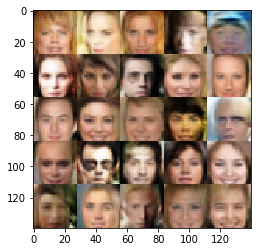

Epoch 1/1... Batch 5010... Discriminator Loss: 0.6667... Generator Loss: 1.5956
Epoch 1/1... Batch 5020... Discriminator Loss: 0.7256... Generator Loss: 2.8778
Epoch 1/1... Batch 5030... Discriminator Loss: 0.6297... Generator Loss: 2.0584
Epoch 1/1... Batch 5040... Discriminator Loss: 0.4385... Generator Loss: 2.6955
Epoch 1/1... Batch 5050... Discriminator Loss: 0.9672... Generator Loss: 1.1228
Epoch 1/1... Batch 5060... Discriminator Loss: 0.6092... Generator Loss: 1.4749
Epoch 1/1... Batch 5070... Discriminator Loss: 0.5101... Generator Loss: 2.1917
Epoch 1/1... Batch 5080... Discriminator Loss: 0.7666... Generator Loss: 3.5150
Epoch 1/1... Batch 5090... Discriminator Loss: 1.5792... Generator Loss: 0.8394
Epoch 1/1... Batch 5100... Discriminator Loss: 0.6265... Generator Loss: 2.5946


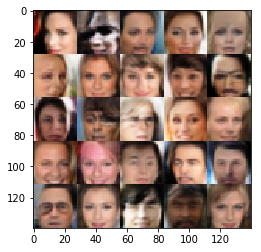

Epoch 1/1... Batch 5110... Discriminator Loss: 0.7041... Generator Loss: 1.6079
Epoch 1/1... Batch 5120... Discriminator Loss: 0.9762... Generator Loss: 1.2544
Epoch 1/1... Batch 5130... Discriminator Loss: 0.4170... Generator Loss: 2.8037
Epoch 1/1... Batch 5140... Discriminator Loss: 0.5581... Generator Loss: 4.5916
Epoch 1/1... Batch 5150... Discriminator Loss: 0.4525... Generator Loss: 2.9294
Epoch 1/1... Batch 5160... Discriminator Loss: 0.9017... Generator Loss: 0.9023
Epoch 1/1... Batch 5170... Discriminator Loss: 0.8333... Generator Loss: 2.8638
Epoch 1/1... Batch 5180... Discriminator Loss: 0.9809... Generator Loss: 1.2536
Epoch 1/1... Batch 5190... Discriminator Loss: 0.7080... Generator Loss: 3.8048
Epoch 1/1... Batch 5200... Discriminator Loss: 0.5512... Generator Loss: 2.3178


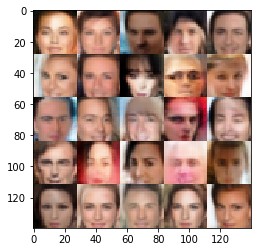

Epoch 1/1... Batch 5210... Discriminator Loss: 0.4632... Generator Loss: 2.9588
Epoch 1/1... Batch 5220... Discriminator Loss: 0.5162... Generator Loss: 2.9144
Epoch 1/1... Batch 5230... Discriminator Loss: 0.5431... Generator Loss: 2.1056
Epoch 1/1... Batch 5240... Discriminator Loss: 0.5467... Generator Loss: 2.3340
Epoch 1/1... Batch 5250... Discriminator Loss: 0.4357... Generator Loss: 3.1866
Epoch 1/1... Batch 5260... Discriminator Loss: 0.4960... Generator Loss: 2.8378
Epoch 1/1... Batch 5270... Discriminator Loss: 0.9830... Generator Loss: 1.3529
Epoch 1/1... Batch 5280... Discriminator Loss: 0.6658... Generator Loss: 2.0392
Epoch 1/1... Batch 5290... Discriminator Loss: 0.9243... Generator Loss: 2.8438
Epoch 1/1... Batch 5300... Discriminator Loss: 0.6626... Generator Loss: 1.5844


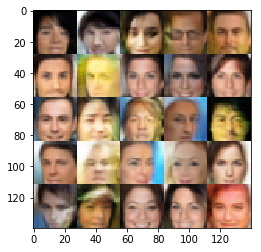

Epoch 1/1... Batch 5310... Discriminator Loss: 0.4494... Generator Loss: 3.0235
Epoch 1/1... Batch 5320... Discriminator Loss: 0.4846... Generator Loss: 2.9374
Epoch 1/1... Batch 5330... Discriminator Loss: 0.7547... Generator Loss: 1.3628
Epoch 1/1... Batch 5340... Discriminator Loss: 0.6423... Generator Loss: 1.9489
Epoch 1/1... Batch 5350... Discriminator Loss: 0.4116... Generator Loss: 3.5829
Epoch 1/1... Batch 5360... Discriminator Loss: 0.3856... Generator Loss: 4.2615
Epoch 1/1... Batch 5370... Discriminator Loss: 0.3777... Generator Loss: 3.1034
Epoch 1/1... Batch 5380... Discriminator Loss: 0.4974... Generator Loss: 2.4937
Epoch 1/1... Batch 5390... Discriminator Loss: 1.0437... Generator Loss: 1.1843
Epoch 1/1... Batch 5400... Discriminator Loss: 0.8138... Generator Loss: 3.3122


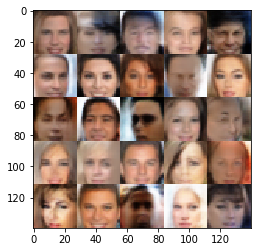

Epoch 1/1... Batch 5410... Discriminator Loss: 0.8762... Generator Loss: 3.2337
Epoch 1/1... Batch 5420... Discriminator Loss: 0.4447... Generator Loss: 2.5970
Epoch 1/1... Batch 5430... Discriminator Loss: 0.4059... Generator Loss: 4.2987
Epoch 1/1... Batch 5440... Discriminator Loss: 0.3919... Generator Loss: 3.0580
Epoch 1/1... Batch 5450... Discriminator Loss: 1.0956... Generator Loss: 4.2791
Epoch 1/1... Batch 5460... Discriminator Loss: 0.4123... Generator Loss: 3.1299
Epoch 1/1... Batch 5470... Discriminator Loss: 0.6060... Generator Loss: 4.7068
Epoch 1/1... Batch 5480... Discriminator Loss: 0.4727... Generator Loss: 2.3138
Epoch 1/1... Batch 5490... Discriminator Loss: 0.4193... Generator Loss: 3.2560
Epoch 1/1... Batch 5500... Discriminator Loss: 0.4156... Generator Loss: 3.1945


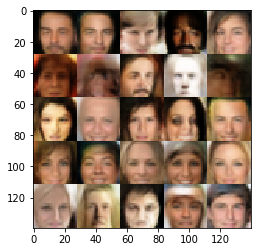

Epoch 1/1... Batch 5510... Discriminator Loss: 1.8367... Generator Loss: 3.9731
Epoch 1/1... Batch 5520... Discriminator Loss: 0.4938... Generator Loss: 3.1560
Epoch 1/1... Batch 5530... Discriminator Loss: 0.6028... Generator Loss: 1.8958
Epoch 1/1... Batch 5540... Discriminator Loss: 1.3496... Generator Loss: 1.0090
Epoch 1/1... Batch 5550... Discriminator Loss: 0.8863... Generator Loss: 1.2687
Epoch 1/1... Batch 5560... Discriminator Loss: 0.4896... Generator Loss: 2.3522
Epoch 1/1... Batch 5570... Discriminator Loss: 1.4569... Generator Loss: 0.5183
Epoch 1/1... Batch 5580... Discriminator Loss: 0.3748... Generator Loss: 3.8072
Epoch 1/1... Batch 5590... Discriminator Loss: 0.4448... Generator Loss: 2.8542
Epoch 1/1... Batch 5600... Discriminator Loss: 0.3994... Generator Loss: 4.2163


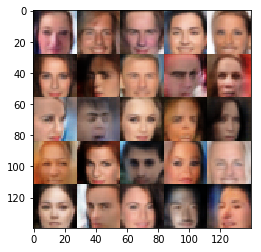

Epoch 1/1... Batch 5610... Discriminator Loss: 0.4855... Generator Loss: 2.1654
Epoch 1/1... Batch 5620... Discriminator Loss: 1.3402... Generator Loss: 3.1868
Epoch 1/1... Batch 5630... Discriminator Loss: 0.7496... Generator Loss: 1.2897
Epoch 1/1... Batch 5640... Discriminator Loss: 0.4886... Generator Loss: 2.8016
Epoch 1/1... Batch 5650... Discriminator Loss: 0.8038... Generator Loss: 3.5418
Epoch 1/1... Batch 5660... Discriminator Loss: 0.8049... Generator Loss: 1.2582
Epoch 1/1... Batch 5670... Discriminator Loss: 0.4777... Generator Loss: 2.7110
Epoch 1/1... Batch 5680... Discriminator Loss: 0.9602... Generator Loss: 0.9376
Epoch 1/1... Batch 5690... Discriminator Loss: 0.4570... Generator Loss: 3.3955
Epoch 1/1... Batch 5700... Discriminator Loss: 0.7874... Generator Loss: 1.4797


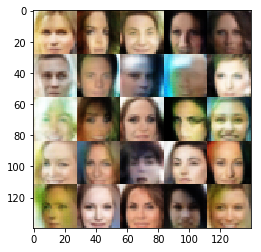

Epoch 1/1... Batch 5710... Discriminator Loss: 0.5120... Generator Loss: 2.3765
Epoch 1/1... Batch 5720... Discriminator Loss: 0.5342... Generator Loss: 3.7731
Epoch 1/1... Batch 5730... Discriminator Loss: 0.7621... Generator Loss: 5.3117
Epoch 1/1... Batch 5740... Discriminator Loss: 0.6485... Generator Loss: 1.9208
Epoch 1/1... Batch 5750... Discriminator Loss: 1.3510... Generator Loss: 1.8908
Epoch 1/1... Batch 5760... Discriminator Loss: 0.6184... Generator Loss: 2.1753
Epoch 1/1... Batch 5770... Discriminator Loss: 0.4851... Generator Loss: 2.3596
Epoch 1/1... Batch 5780... Discriminator Loss: 0.4191... Generator Loss: 3.3803
Epoch 1/1... Batch 5790... Discriminator Loss: 0.3894... Generator Loss: 4.3245
Epoch 1/1... Batch 5800... Discriminator Loss: 0.5171... Generator Loss: 2.3499


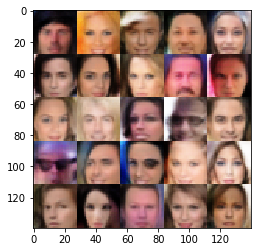

Epoch 1/1... Batch 5810... Discriminator Loss: 1.6170... Generator Loss: 0.5510
Epoch 1/1... Batch 5820... Discriminator Loss: 0.4587... Generator Loss: 3.1688
Epoch 1/1... Batch 5830... Discriminator Loss: 0.4334... Generator Loss: 2.4766
Epoch 1/1... Batch 5840... Discriminator Loss: 0.5327... Generator Loss: 2.1532
Epoch 1/1... Batch 5850... Discriminator Loss: 0.4621... Generator Loss: 4.5367
Epoch 1/1... Batch 5860... Discriminator Loss: 0.6253... Generator Loss: 1.7440
Epoch 1/1... Batch 5870... Discriminator Loss: 0.5164... Generator Loss: 2.6522
Epoch 1/1... Batch 5880... Discriminator Loss: 0.6474... Generator Loss: 2.7764
Epoch 1/1... Batch 5890... Discriminator Loss: 0.5950... Generator Loss: 4.9739
Epoch 1/1... Batch 5900... Discriminator Loss: 0.9044... Generator Loss: 2.8039


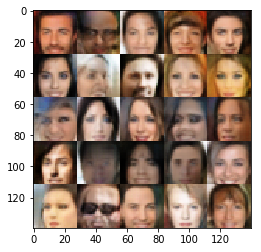

Epoch 1/1... Batch 5910... Discriminator Loss: 0.4494... Generator Loss: 2.9943
Epoch 1/1... Batch 5920... Discriminator Loss: 0.4502... Generator Loss: 4.0557
Epoch 1/1... Batch 5930... Discriminator Loss: 1.0769... Generator Loss: 3.8610
Epoch 1/1... Batch 5940... Discriminator Loss: 0.6904... Generator Loss: 1.2953
Epoch 1/1... Batch 5950... Discriminator Loss: 0.4963... Generator Loss: 2.3455
Epoch 1/1... Batch 5960... Discriminator Loss: 0.6638... Generator Loss: 1.8028
Epoch 1/1... Batch 5970... Discriminator Loss: 0.6932... Generator Loss: 1.6814
Epoch 1/1... Batch 5980... Discriminator Loss: 0.4759... Generator Loss: 2.4261
Epoch 1/1... Batch 5990... Discriminator Loss: 0.4065... Generator Loss: 3.1134
Epoch 1/1... Batch 6000... Discriminator Loss: 0.7163... Generator Loss: 1.4002


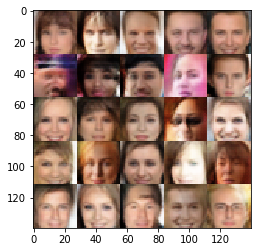

Epoch 1/1... Batch 6010... Discriminator Loss: 0.6113... Generator Loss: 1.9609
Epoch 1/1... Batch 6020... Discriminator Loss: 0.9673... Generator Loss: 2.6335
Epoch 1/1... Batch 6030... Discriminator Loss: 1.0736... Generator Loss: 3.6542
Epoch 1/1... Batch 6040... Discriminator Loss: 1.1889... Generator Loss: 0.9660
Epoch 1/1... Batch 6050... Discriminator Loss: 1.1545... Generator Loss: 1.0046
Epoch 1/1... Batch 6060... Discriminator Loss: 0.5635... Generator Loss: 2.1634
Epoch 1/1... Batch 6070... Discriminator Loss: 0.4560... Generator Loss: 2.5459
Epoch 1/1... Batch 6080... Discriminator Loss: 0.9402... Generator Loss: 1.4470
Epoch 1/1... Batch 6090... Discriminator Loss: 0.5767... Generator Loss: 2.2867
Epoch 1/1... Batch 6100... Discriminator Loss: 0.3700... Generator Loss: 4.4826


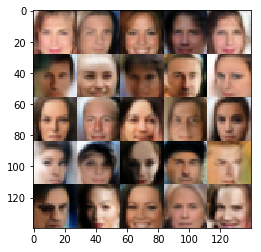

Epoch 1/1... Batch 6110... Discriminator Loss: 0.8259... Generator Loss: 1.2931
Epoch 1/1... Batch 6120... Discriminator Loss: 0.7103... Generator Loss: 1.2186
Epoch 1/1... Batch 6130... Discriminator Loss: 0.5060... Generator Loss: 2.4408
Epoch 1/1... Batch 6140... Discriminator Loss: 0.4580... Generator Loss: 3.1708
Epoch 1/1... Batch 6150... Discriminator Loss: 0.4885... Generator Loss: 4.4281
Epoch 1/1... Batch 6160... Discriminator Loss: 0.7096... Generator Loss: 1.6591
Epoch 1/1... Batch 6170... Discriminator Loss: 0.5249... Generator Loss: 2.9614
Epoch 1/1... Batch 6180... Discriminator Loss: 0.8281... Generator Loss: 1.9576
Epoch 1/1... Batch 6190... Discriminator Loss: 0.6774... Generator Loss: 1.6093
Epoch 1/1... Batch 6200... Discriminator Loss: 0.3911... Generator Loss: 3.5425


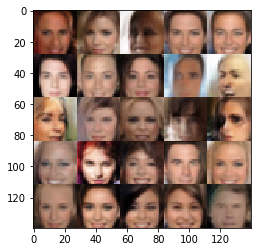

Epoch 1/1... Batch 6210... Discriminator Loss: 0.6043... Generator Loss: 1.6659
Epoch 1/1... Batch 6220... Discriminator Loss: 0.4271... Generator Loss: 2.4263
Epoch 1/1... Batch 6230... Discriminator Loss: 0.5206... Generator Loss: 4.5862
Epoch 1/1... Batch 6240... Discriminator Loss: 0.5660... Generator Loss: 1.9315
Epoch 1/1... Batch 6250... Discriminator Loss: 0.4203... Generator Loss: 3.6837
Epoch 1/1... Batch 6260... Discriminator Loss: 0.7410... Generator Loss: 1.6608
Epoch 1/1... Batch 6270... Discriminator Loss: 1.2528... Generator Loss: 1.2574
Epoch 1/1... Batch 6280... Discriminator Loss: 0.5726... Generator Loss: 2.3963
Epoch 1/1... Batch 6290... Discriminator Loss: 0.8423... Generator Loss: 1.0037
Epoch 1/1... Batch 6300... Discriminator Loss: 0.4443... Generator Loss: 2.7699


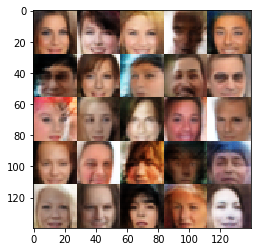

Epoch 1/1... Batch 6310... Discriminator Loss: 0.4346... Generator Loss: 3.1094
Epoch 1/1... Batch 6320... Discriminator Loss: 0.5759... Generator Loss: 1.4075
Epoch 1/1... Batch 6330... Discriminator Loss: 0.4687... Generator Loss: 2.5564


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.